In [21]:
import math
import numpy as np

# Constants
rho0 = 1.225  # Sea level air density (kg/m^3)
h = [0, 3000, 12500, 0]  # Altitudes in meters (takeoff, climb, cruise, landing)
Cd0 = 0.020  # Parasitic drag coefficient 
delta = 0.005  # Induced drag correction factor
AR = 4.5 # Effective  Aspect ratio
CL = [1, 0.5, 0.261, 1.7]  # Adjusted Lift coefficients for phases (lower landing CL)
S = 184.03   # Wing area (m^2)
W = 475995.297  # Aircraft weight (N) 107008 lb
gamma = 3 # Climb angle in degrees
v = [80, 160, 266, 65]  # Speeds (m/s) for each phase
e = 0.95 # oswalds efficiency 

# Drag coefficients
Cd = np.array([Cd0 + ((cl ** 2) / (math.pi * AR * e)) * (1 + delta) for cl in CL])
cd = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, cd in enumerate(cd):
    print(f"{cd} Cd: {Cd[i]:.2f} ")

# Density function
def rho(h):
    rho0 = 1.225
    sea_level_temp = 288.15
    lapse_rate = -0.0065
    R = 287.05
    g = 9.80665
    tropopause_height = 11000

    if isinstance(h, (list, np.ndarray)):
        return np.array([rho(alt) for alt in h])
    if h <= tropopause_height:
        temperature = sea_level_temp + lapse_rate * h
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R))
    else:
        temperature = sea_level_temp + lapse_rate * tropopause_height
        exp_factor = (-g * (h - tropopause_height)) / (R * temperature)
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R)) * math.exp(exp_factor)

# Dynamic pressure calculation
def dynamic_pressure(V, h):
    densities = rho(h)
    return 0.5 * densities * np.array(V)**2

# Drag 
def Drag (Cd, q, S):
    return Cd * q * S

# Additional Drag  for climb
def Drag_climb(W, gamma):
    gamma_rad = math.radians(gamma)
    return W * math.sin(gamma_rad)

# Drag  calculations for each segment
q = dynamic_pressure(v, h)  # Dynamic pressure for each segment
T = [Drag(Cd[i], q[i], S) for i in range(len(v))]
T[1] += Drag_climb(W, gamma)  # Add climb-specific Drag 

# Segment Results
segments = ["Takeoff", "Climb", "Cruise", "Landing"]
print("Dynamic Pressures for each segment:")
for i, segment in enumerate(segments):
    print(f"{segment}: {q[i]:.2f} Pa")

# Output Drag  for each phase
for i, segment in enumerate(segments):
    print(f"{segment} Drag : {T[i]:.2f} N")
# Additional checks for drag and thrust comparison
#print("\nClimb vs Landing Drag Comparison:")
#print(f"Climb Drag: {T[1]:.2f} N")
#print(f"Landing Drag: {T[3]:.2f} N")


Takeoff Cd: 0.09 
Climb Cd: 0.04 
Cruise Cd: 0.03 
Landing Cd: 0.24 
Dynamic Pressures for each segment:
Takeoff: 3920.00 Pa
Climb: 10849.22 Pa
Cruise: 7640.89 Pa
Landing: 2587.81 Pa
Takeoff Drag : 68410.67 N
Climb Drag : 102194.77 N
Cruise Drag : 35291.00 N
Landing Drag : 112515.72 N


In [41]:
import numpy as np

# Constants (Anderson's ISA Model)
g = 9.80665  # Gravity (m/s²)
R = 287.05  # Gas constant for air (J/kg·K)
T0 = 288.15  # Sea-level standard temperature (K)
p0 = 101325  # Sea-level pressure (Pa)
rho0 = 1.225  # Sea-level density (kg/m³)
L = 0.0065  # Temperature lapse rate (K/m)

# ISA Atmospheric Model Function (Corrected for Anderson’s Equations)
def density(alt_ft):
    """Compute air density at a given altitude using Anderson’s ISA model."""
    alt_m = alt_ft * 0.3048  # Convert feet to meters

    if alt_m <= 11000:  # Troposphere case
        T = T0 - L * alt_m
        p = p0 * (T / T0) ** (g / (L * R))
    else:  # Stratosphere case (Above 11,000m)
        T = 216.65  # Constant temperature
        p_11 = p0 * (T / T0) ** (g / (L * R))  # Pressure at 11,000m
        p = p_11 * np.exp(-g * (alt_m - 11000) / (R * T))

    rho = p / (R * T)  # Density calculation from ideal gas law
    return rho

# Flight conditions (CL values, speeds, and altitudes)
flight_segments = {
    "Takeoff": {"CL": 1.0, "V_knots": 156, "gamma_deg": 5, "alt_ft": 0},
    "Climb": {"CL": 0.5, "V_knots": 260, "ROC_fpm": 1500, "alt_ft": 4000},  # Reduced ROC for realistic gamma
    "Cruise": {"CL": 0.261, "V_knots": 517, "gamma_deg": 0, "alt_ft": 41000},
    "Landing": {"CL": 1.2, "V_knots": 130, "gamma_deg": -3, "alt_ft": 0}  # Reduced CL in landing
}

# Convert speeds from knots to m/s
for segment in flight_segments:
    flight_segments[segment]["V"] = flight_segments[segment]["V_knots"] * 0.514444

# Function to calculate required thrust
def required_thrust(CL, V, alt_ft, gamma_deg=None, ROC_fpm=None, is_landing=False):
    rho = density(alt_ft)  # Use Anderson’s ISA density model
    A = 4.5  # Aspect Ratio (adjust for BWB)
    e = 0.95  # Oswald efficiency factor
    CD0 = 0.02  # Parasitic drag coefficient
    S_ft2 = 2011.66722  # Wing area in ft²
    S = S_ft2 * 0.092903  # Convert ft² to m²
    W_lbf = 107008  # Aircraft weight in lbf
    W = W_lbf * 4.44822  # Convert lbf to Newtons

    # Compute drag coefficient
    CD = CD0 + (CL ** 2) / (np.pi * A * e)

    # Adjust for landing gear and flap drag but **reduce overestimation**
   # if is_landing:
   #     CD += 0.01  # Reduced additional drag

    # Compute drag force
    D = 0.5 * rho * V**2 * S * CD  

    # Compute gamma correctly and **limit gamma in climb**
    if ROC_fpm is not None:
        ROC = ROC_fpm * 0.00508  # Convert ft/min to m/s
        gamma = min(np.arcsin(ROC / V), np.radians(5))  # **Limit gamma to max 5°**
    else:
        gamma = np.radians(gamma_deg)  # Convert gamma to radians if provided

    # Compute required thrust
    T_req = D + W * np.sin(gamma)
    return T_req

# Compute thrust for each flight segment
for segment, params in flight_segments.items():
    T_req = required_thrust(params["CL"], params["V"], params["alt_ft"], 
                            gamma_deg=params.get("gamma_deg"), 
                            ROC_fpm=params.get("ROC_fpm"), 
                            is_landing=(segment == "Landing"))
    
    print(f"{segment}: Required Thrust = {T_req:.2f} N ({T_req / 4.44822:.2f} lbf)")


Takeoff: Required Thrust = 111126.32 N (24982.20 lbf)
Climb: Required Thrust = 97347.73 N (21884.65 lbf)
Cruise: Required Thrust = 47632.08 N (10708.12 lbf)
Landing: Required Thrust = 40223.46 N (9042.60 lbf)


In [45]:
import numpy as np

# Constants (Anderson's ISA Model)
g = 9.80665  # Gravity (m/s²)
R = 287.05  # Gas constant for air (J/kg·K)
T0 = 288.15  # Sea-level standard temperature (K)
p0 = 101325  # Sea-level pressure (Pa)
rho0 = 1.225  # Sea-level air density (kg/m³)
L = 0.0065  # Temperature lapse rate (K/m)

# Pratt & Whitney PW1521G Sea-Level Static Thrust (Per Engine)
T_SL_per_engine =21970 * 4.44822  # Convert from lbf to Newtons
num_engines = 2  # **Your aircraft has 2 engines**
T_SL_total = T_SL_per_engine * num_engines  # Total thrust

n = 0.7  # Typical exponent for turbofan engines

# ISA Atmospheric Model Function
def density(alt_ft):
    """Compute air density at a given altitude using Anderson’s ISA model."""
    alt_m = alt_ft * 0.3048  # Convert feet to meters

    if alt_m <= 11000:  # Troposphere case
        T = T0 - L * alt_m
        p = p0 * (T / T0) ** (g / (L * R))
    else:  # Stratosphere case (Above 11,000m)
        T = 216.65  # Constant temperature
        p_11 = p0 * (T / T0) ** (g / (L * R))  # Pressure at 11,000m
        p = p_11 * np.exp(-g * (alt_m - 11000) / (R * T))

    rho = p / (R * T)  # Density calculation from ideal gas law
    return rho

# Flight Segments and Altitudes
flight_segments = {
    "Takeoff": {"alt_ft": 0},
    "Climb": {"alt_ft": 4000},
    "Cruise": {"alt_ft": 41000},
    "Landing": {"alt_ft": 0}
}

# Compute available thrust at each flight segment
for segment, params in flight_segments.items():
    rho = density(params["alt_ft"])
    T_avail = T_SL_total * (rho / rho0) ** n  # Anderson's formula

    print(f"{segment}: Available Thrust = {T_avail:.2f} N ({T_avail / 4.44822:.2f} lbf)")


Takeoff: Available Thrust = 195456.16 N (43940.31 lbf)
Climb: Available Thrust = 179873.65 N (40437.22 lbf)
Cruise: Available Thrust = 70843.01 N (15926.15 lbf)
Landing: Available Thrust = 195456.16 N (43940.31 lbf)


In [49]:
#Thrust Margin for each flight segment 
import numpy as np

# Constants (Anderson's ISA Model)
g = 9.80665  # Gravity (m/s²)
R = 287.05  # Gas constant for air (J/kg·K)
T0 = 288.15  # Sea-level standard temperature (K)
p0 = 101325  # Sea-level pressure (Pa)
rho0 = 1.225  # Sea-level air density (kg/m³)
L = 0.0065  # Temperature lapse rate (K/m)

# Pratt & Whitney PW1521G Sea-Level Static Thrust (Per Engine)
T_SL_per_engine = 17000 * 4.44822  # Convert from lbf to Newtons
num_engines = 2  # Your aircraft has 2 engines
T_SL_total = T_SL_per_engine * num_engines  # Total available thrust

n = 0.7  # Typical exponent for turbofan engines

# ISA Atmospheric Model Function
def density(alt_ft):
    """Compute air density at a given altitude using Anderson’s ISA model."""
    alt_m = alt_ft * 0.3048  # Convert feet to meters

    if alt_m <= 11000:  # Troposphere case
        T = T0 - L * alt_m
        p = p0 * (T / T0) ** (g / (L * R))
    else:  # Stratosphere case (Above 11,000m)
        T = 216.65  # Constant temperature
        p_11 = p0 * (T / T0) ** (g / (L * R))  # Pressure at 11,000m
        p = p_11 * np.exp(-g * (alt_m - 11000) / (R * T))

    rho = p / (R * T)  # Density calculation from ideal gas law
    return rho

# Flight conditions (CL values, speeds, and altitudes)
flight_segments = {
    "Takeoff": {"CL": 1.0, "V_knots": 156, "gamma_deg": 5, "alt_ft": 0},
    "Climb": {"CL": 0.5, "V_knots": 260, "ROC_fpm": 1500, "alt_ft": 4000},
    "Cruise": {"CL": 0.261, "V_knots": 517, "gamma_deg": 0, "alt_ft": 41000},
    "Landing": {"CL": 1.2, "V_knots": 126, "gamma_deg": -3, "alt_ft": 0}
}

# Convert speeds from knots to m/s
for segment in flight_segments:
    flight_segments[segment]["V"] = flight_segments[segment]["V_knots"] * 0.514444

# Function to calculate required thrust
def required_thrust(CL, V, alt_ft, gamma_deg=None, ROC_fpm=None, is_landing=False):
    rho = density(alt_ft)  # Use Anderson’s ISA density model
    A = 4.5  # Aspect Ratio (adjust for BWB)
    e = 0.95  # Oswald efficiency factor
    CD0 = 0.02  # Parasitic drag coefficient
    S_ft2 = 2011.66722  # Wing area in ft²
    S = S_ft2 * 0.092903  # Convert ft² to m²
    W_lbf = 107008  # Aircraft weight in lbf
    W = W_lbf * 4.44822  # Convert lbf to Newtons

    # Compute drag coefficient
    CD = CD0 + (CL ** 2) / (np.pi * A * e)

    # Adjust for landing gear and flap drag
   # if is_landing:
   #     CD += 0.01  # Reduced additional drag

    # Compute drag force
    D = 0.5 * rho * V**2 * S * CD  

    # Compute gamma correctly and limit gamma in climb
    if ROC_fpm is not None:
        ROC = ROC_fpm * 0.00508  # Convert ft/min to m/s
        gamma = min(np.arcsin(ROC / V), np.radians(5))  # Limit gamma to max 5°
    else:
        gamma = np.radians(gamma_deg)  # Convert gamma to radians if provided

    # Compute required thrust
    T_req = D + W * np.sin(gamma)
    return T_req

# Compute available thrust, required thrust, and thrust margin
print("\nThrust Analysis:\n")
for segment, params in flight_segments.items():
    # Compute available thrust
    rho = density(params["alt_ft"])
    T_avail = T_SL_total * (rho / rho0) ** n  # Anderson's formula
    
    # Compute required thrust
    T_req = required_thrust(params["CL"], params["V"], params["alt_ft"], 
                            gamma_deg=params.get("gamma_deg"), 
                            ROC_fpm=params.get("ROC_fpm"), 
                            is_landing=(segment == "Landing"))
    
    # Compute thrust margin in percentage
    T_margin = T_avail - T_req
    T_margin_percent = (T_margin / T_req) * 100  # Convert to percentage

    # Display Results
    print(f"{segment}:")
    print(f"  Available Thrust: {T_avail:.2f} N ({T_avail / 4.44822:.2f} lbf)")
    print(f"  Required Thrust:  {T_req:.2f} N ({T_req / 4.44822:.2f} lbf)")
    print(f"  Thrust Margin:    {T_margin:.2f} N ({T_margin / 4.44822:.2f} lbf)")
    print(f"  Thrust Margin:    {T_margin_percent:.2f} %")

    # Check if thrust margin is below recommended levels
    if T_margin_percent < 10:  # FAA FAR Part 25 typically requires a 10% margin
        print("  ⚠️ Warning: Low thrust margin! Check for performance issues.\n")
    else:
        print("  ✅ Sufficient thrust available.\n")



Thrust Analysis:

Takeoff:
  Available Thrust: 151240.54 N (34000.24 lbf)
  Required Thrust:  111126.32 N (24982.20 lbf)
  Thrust Margin:    40114.22 N (9018.04 lbf)
  Thrust Margin:    36.10 %
  ✅ Sufficient thrust available.

Climb:
  Available Thrust: 139183.07 N (31289.61 lbf)
  Required Thrust:  97347.73 N (21884.65 lbf)
  Thrust Margin:    41835.34 N (9404.96 lbf)
  Thrust Margin:    42.98 %
  ✅ Sufficient thrust available.

Cruise:
  Available Thrust: 54817.07 N (12323.37 lbf)
  Required Thrust:  47632.08 N (10708.12 lbf)
  Thrust Margin:    7184.99 N (1615.25 lbf)
  Thrust Margin:    15.08 %
  ✅ Sufficient thrust available.

Landing:
  Available Thrust: 151240.54 N (34000.24 lbf)
  Required Thrust:  36276.81 N (8155.35 lbf)
  Thrust Margin:    114963.73 N (25844.88 lbf)
  Thrust Margin:    316.91 %
  ✅ Sufficient thrust available.



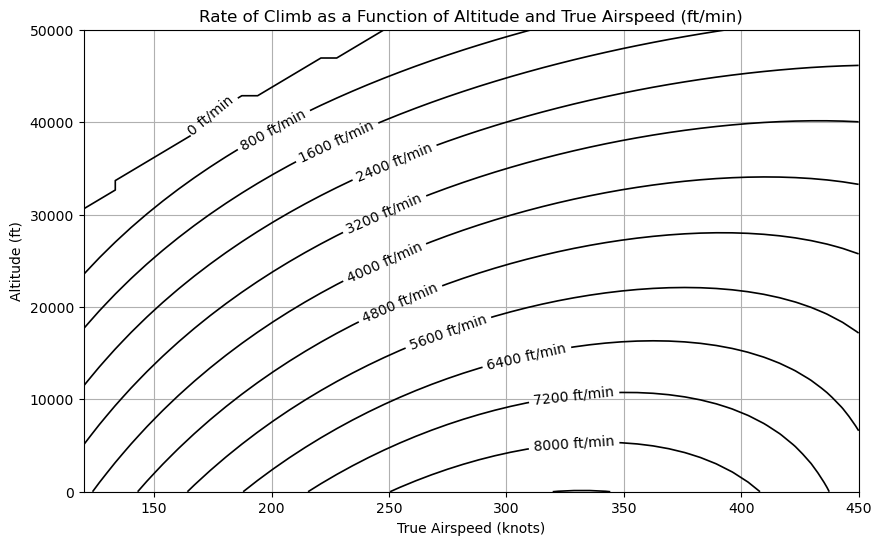

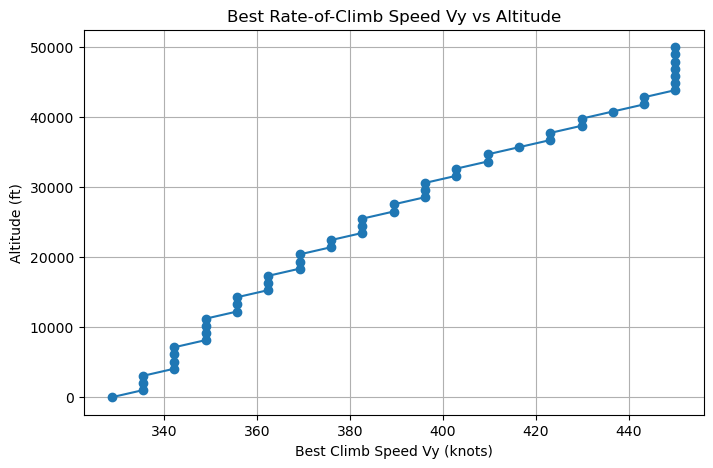

Fuel burned during climb: 1952.93 kg
Fuel burned during cruise: 14334.16 kg
Fuel burned during descent: 703.93 kg
Total Fuel burned : 16991.01 kg


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ISA Density function
def density(alt_ft):
    alt_m = alt_ft * 0.3048  
    T0 = 288.15  # K
    p0 = 101325  # Pa
    L = 0.0065   # K/m
    g = 9.80665  # m/s²
    R = 287.058  # J/(kg*K)

    T = T0 - L * alt_m  
    p = p0 * (T / T0) ** (g / (R * L))
    rho = p / (R * T)
    return rho

# Aircraft & Performance Parameters
rho0 = 1.225  # Sea-level air density (kg/m³)
W_lbf = 106000  
W = W_lbf * 4.44822  # Weight in Newtons
S_ft2 = 2011.66722       
S = S_ft2 * 0.092903  # Wing area in m²
T0_lbf =21970 *2   # static thrust in lbf 
T0 = T0_lbf * 4.44822  # Sea-level thrust (N)
C_D0 = 0.02  # Zero-lift drag coefficient
A = 4.5  # Aspect ratio
e = 0.95  # Oswald efficiency factor

# Engine Parameters
TSFC0_takeoff = 0.35 / 3600  # Sea-level TSFC for takeoff (1/s)
TSFC0_cruise =  0.420/ 3600  # Sea-level TSFC for cruise (1/s)

altitudes = np.linspace(0, 50000, 50)  # Altitudes (ft)
airspeeds_knots = np.linspace(120, 450, 50)  # True Airspeeds (knots)
ROC = np.zeros((len(altitudes), len(airspeeds_knots)))

# Compute Rate of Climb (ROC)
for i, alt in enumerate(altitudes):
    rho = density(alt)
    T_available = T0 * (rho / rho0) ** 0.7  # Turbofan thrust decay
    
    for j, tas_knots in enumerate(airspeeds_knots):
        V = tas_knots * 0.514444  # Convert knots to m/s
        Mach = V / np.sqrt(1.4 * 287 * (288.15 - 0.0065 * alt * 0.3048))
        
        # Compute TSFC Correction for Climb
        TSFC_climb = TSFC0_takeoff * (rho / rho0) ** -0.3 * (1 + 0.2 * Mach)
        
        # Compute Lift Coefficient (C_L)
        C_L = (2 * W) / (rho * V**2 * S)

        # Compute Drag Coefficient (C_D)
        C_D = C_D0 + (C_L**2) / (np.pi * A * e)

        # Compute Drag Force (D)
        D = 0.5 * rho * V**2 * S * C_D  

        # Compute Excess Thrust (T - D)
        excess_thrust = T_available - D

        # Compute ROC in m/s
        roc_ms = V * excess_thrust / W
        roc_ft_min = roc_ms * 3.28084 * 60  # Convert to ft/min

        ROC[i, j] = max(roc_ft_min, 0)  # No negative ROC values

# Plot Results
plt.figure(figsize=(10, 6))
contour = plt.contour(airspeeds_knots, altitudes, ROC, levels=12, colors='black', linewidths=1.2)
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.0f ft/min')
plt.xlabel('True Airspeed (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Rate of Climb as a Function of Altitude and True Airspeed (ft/min)')
plt.grid(True)
plt.show()

# Find Best Climb Speed (Vy) for each altitude
Vy_list = []
for i, alt in enumerate(altitudes):
    best_speed_idx = np.argmax(ROC[i, :])
    Vy_list.append(airspeeds_knots[best_speed_idx])

# Plot Best Climb Speed (Vy) vs Altitude
plt.figure(figsize=(8, 5))
plt.plot(Vy_list, altitudes, marker='o', linestyle='-')
plt.xlabel('Best Climb Speed Vy (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Best Rate-of-Climb Speed Vy vs Altitude')
plt.grid(True)
plt.show()

# Compute Fuel Burn using Breguet Range Equation for Different Phases
R_climb = 740800  # Climb range in meters 5% of the total range 
R_cruise =13037080# Cruise range in meters 88% 
R_descent = 889000 # Descent range in meters 6%
LD_max = 15 #  L/D
Wi = W  # Initial weight

# TSFC for Cruise and Descent
TSFC_cruise = TSFC0_cruise * 0.85  # Cruise correction
TSFC_descent = TSFC0_cruise * 0.75  # Descent correction

# Fuel Burn Calculation
fuel_burn_fraction_climb = 1 - np.exp(-TSFC_climb * R_climb / (V * LD_max))
fuel_burn_fraction_cruise = 1 - np.exp(-TSFC_cruise * R_cruise / (V * LD_max))
fuel_burn_fraction_descent = 1 - np.exp(-TSFC_descent * R_descent / (V * LD_max))

Wf_climb = Wi * (1 - fuel_burn_fraction_climb)
Wf_cruise = Wf_climb * (1 - fuel_burn_fraction_cruise)
Wf_descent = Wf_cruise * (1 - fuel_burn_fraction_descent)


fuel_burned_climb_kg = (Wi - Wf_climb) / 9.81
fuel_burned_cruise_kg = (Wf_climb - Wf_cruise) / 9.81
fuel_burned_descent_kg = (Wf_cruise - Wf_descent) / 9.81
Total_fuel_burn_kg = fuel_burned_climb_kg + fuel_burned_cruise_kg + fuel_burned_descent_kg

print(f"Fuel burned during climb: {fuel_burned_climb_kg:.2f} kg")
print(f"Fuel burned during cruise: {fuel_burned_cruise_kg:.2f} kg")
print(f"Fuel burned during descent: {fuel_burned_descent_kg:.2f} kg")
print(f"Total Fuel burned : {Total_fuel_burn_kg:.2f} kg")


In [ ]:
# Function to calculate air density using the ISA model
# Up to 11 km (Troposphere)
R = 287.05  # [m^2/s^2K]
gamma = 1.4
T_0 = 288.15 #[K]
rho_0 = 1.225  #[kg/m^3]
g = 9.81 #[m/s^2]
L =  0.0065
p_0 = 101325

def air_density(altitude):
    # Up to 11 km (Troposphere)
    if altitude <= 11000:
        T = T_0 - L * altitude  # Temperature [K]
        p = p_0 * (T / 288.15) ** 5.2561  # Pressure [Pa]
    else:
        # Simplification for stratosphere, constant T [K] above 11 km
        T = 216.65  # Constant temperature [K]
        p = 22632 * np.exp(-9.81 * (altitude - 11000) / (287.05 * T))
    rho = p / (287.05 * T)  # Air density [kg/m^3]
    return rho, T, p

In [53]:
import numpy as np
#still iterating 
# Engine & Fuel Parameters
TSFC_static = 0.000013  # kg/N/s for PW1521G
altitude_corrections = [1.0, 0.95, 0.9, 1.0]  # Takeoff, climb, cruise, landing
mach_corrections = [1.0, 0.9, 0.85, 1.0]  # Takeoff, climb, cruise, landing
fuel_density = 0.8  # kg/L (Jet-A)
MTOW_lbs = 106000  # Maximum Takeoff Weight in pounds
MTOW_kg = MTOW_lbs * 0.453592  # Convert to kg
# Flight Parameters
durations = [120, 900, 55795, 600]  # Time in seconds (Takeoff, Climb, Cruise, Landing)
thrusts = [144884.78, 83085.52, 42676.98, 38800.00]  # Corrected thrust values (N per phase)
cruise_speed = 266  # Cruise speed in m/s (450 knots)
cruise_range = 7040 * 1852  # Cruise range in meters (7040  nautical miles)
L_D_ratio = 15  # Lift-to-drag ratio during cruise

# Function to compute fuel burn using Breguet equation for cruise
def compute_fuel_burn(tsfc, thrusts, durations, altitude_corrections, mach_corrections, cruise_speed, cruise_range, L_D_ratio):
    fuel_burn = []
    initial_weight = MTOW_kg  # Start with MTOW

    for i, phase in enumerate(["Takeoff", "Climb", "Cruise", "Landing"]):
        if phase == "Cruise":
            # Use Breguet equation for cruise
            g = 9.80665  # Gravitational acceleration (m/s²)
            tsfc_corrected = tsfc * altitude_corrections[i] * mach_corrections[i]
            exponent = (-cruise_range * g * tsfc_corrected) / (cruise_speed * L_D_ratio)
            final_weight = initial_weight * np.exp(exponent)
            fuel_burn_phase = initial_weight - final_weight
            initial_weight = final_weight  # Update initial weight for next phase
        else:
            # Use thrust and duration for other phases
            tsfc_corrected = tsfc * altitude_corrections[i] * mach_corrections[i]
            fuel_rate = tsfc_corrected * thrusts[i]  # kg/s
            fuel_burn_phase = fuel_rate * durations[i]  # kg
            initial_weight -= fuel_burn_phase  # Update initial weight for next phase

        fuel_burn.append(fuel_burn_phase)

    return fuel_burn

# Calculate total fuel burn per phase
fuel_burn_per_phase = compute_fuel_burn(TSFC_static, thrusts, durations, altitude_corrections, mach_corrections, cruise_speed, cruise_range, L_D_ratio)
total_fuel_burn = sum(fuel_burn_per_phase)

# Convert to fuel volume (liters)
fuel_volume_liters = total_fuel_burn / fuel_density
fuel_volume_gallons = fuel_volume_liters / 3.785  # Convert to US gallons

# Print results
phases = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, phase in enumerate(phases):
    print(f"{phase}:")
    print(f"  Fuel Burn: {fuel_burn_per_phase[i]:.2f} kg")

print(f"\nTotal Fuel Burn: {total_fuel_burn:.2f} kg")
print(f"Fuel Volume: {fuel_volume_liters:.2f} L ({fuel_volume_gallons:.2f} US gallons)")
print(f"Maximum Takeoff Weight (MTOW): {MTOW_kg:.2f} kg ({MTOW_lbs} lbs)")

Takeoff:
  Fuel Burn: 226.02 kg
Climb:
  Fuel Burn: 831.15 kg
Cruise:
  Fuel Burn: 12832.64 kg
Landing:
  Fuel Burn: 302.64 kg

Total Fuel Burn: 14192.44 kg
Fuel Volume: 17740.55 L (4687.07 US gallons)
Maximum Takeoff Weight (MTOW): 48080.75 kg (106000 lbs)


In [4]:
import math

def isa_temperature(altitude):
    """
    Calculate the ambient temperature at a given altitude using the ISA model.

    Parameters:
        altitude (float): Altitude in feet.

    Returns:
        float: Ambient temperature in Kelvin.
    """
    # ISA constants
    T0 = 288.15  # Sea level standard temperature in Kelvin
    lapse_rate = -0.0065  # Temperature lapse rate in K/m
    altitude_m = altitude * 0.3048  # Convert altitude from feet to meters

    # Calculate ambient temperature
    if altitude_m <= 11000:  # Troposphere (0–11,000 m)
        T = T0 + lapse_rate * altitude_m
    else:
        # For simplicity, assume constant temperature in the stratosphere
        T = 216.65  # Temperature at 11,000 m in Kelvin

    return T

def calculate_corrected_tsfc(tsfc0, altitude, M, n):
    """
    Calculate the corrected TSFC using the formula:
    TSFC = TSFC0 * sqrt(theta) * (1 + M)^n

    Parameters:
        tsfc0 (float): Baseline TSFC at sea level static conditions.
        altitude (float): Altitude in feet.
        M (float): Mach number.
        n (float): Empirical constant (typically between 0.2 and 0.5).

    Returns:
        float: Corrected TSFC.
    """
    # Standard sea level temperature in Kelvin
    T0 = 288.15

    # Calculate ambient temperature using the ISA model
    T = isa_temperature(altitude)

    # Calculate temperature ratio (theta)
    theta = T / T0

    # Calculate corrected TSFC
    corrected_tsfc = tsfc0 * math.sqrt(theta) * ((1 + M) ** n)

    return corrected_tsfc

# Example usage
if __name__ == "__main__":
    # Input parameters
    tsfc0 = 0.35  # Baseline TSFC in lb/lbf·hr
    altitude = 35000  # Altitude in feet
    M = 0.9  # Mach number
    n = 0.5  # Empirical constant

    # Calculate corrected TSFC
    corrected_tsfc = calculate_corrected_tsfc(tsfc0, altitude, M, n)

    # Print the result
    print(f"Corrected TSFC at {altitude} ft: {corrected_tsfc:.4f} lb/lbf·hr")

Corrected TSFC at 35000 ft: 0.4204 lb/lbf·hr


H = 0, M = 0.24, TR = 1, deltaOAT_C = 0
delta = 1.0409143797394875, theta = 1.01152
Thrust (before max) = 74725.7129852567
Takeoff: 149451.43 N (total for 2 engines)
H = 5000, M = 0.5, TR = 0.96, deltaOAT_C = -5
delta = 0.6553394265096147, theta = 0.9133524206142634
Thrust (before max) = 41542.762280825766
Climb: 83085.52 N (total for 2 engines)
H = 12500, M = 0.9, TR = 0.9, deltaOAT_C = -10
delta = 0.4110743053489163, theta = 0.8333413152871768
Thrust (before max) = 21338.490171256508
Cruise: 42676.98 N (total for 2 engines)
H = 0, M = 0.2, TR = 0.7, deltaOAT_C = 5
delta = 1.106403269179531, theta = 1.0254908901613742
Thrust (before max) = 22158.553453584605
Landing: 44317.11 N (total for 2 engines)


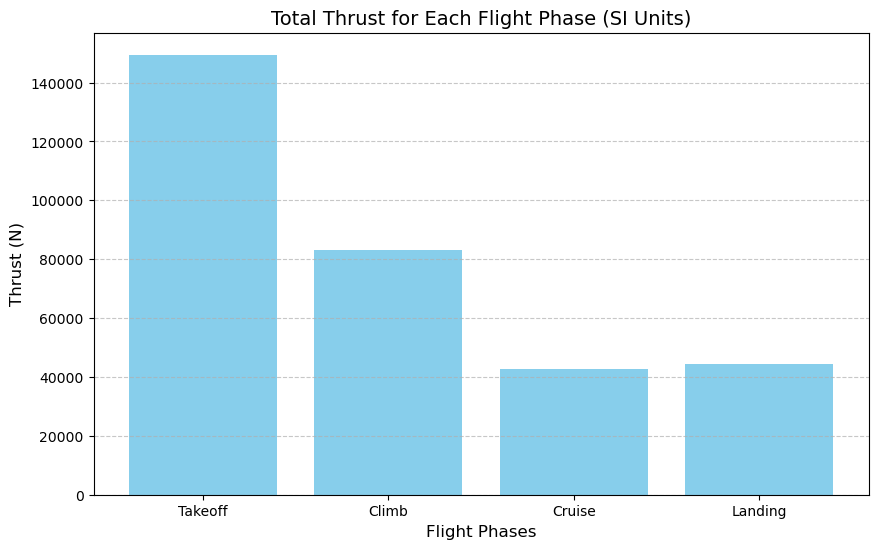

In [41]:
def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine as a function of altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = 216.65 + deltaOAT_C
        P = 22632.1 * math.exp(-9.80665 * (H - 11000) / (R * T))
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = sigma * (1 + 0.2 * M ** 2) ** 3.5  # Pressure ratio
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # Debugging prints
    print(f"H = {H}, M = {M}, TR = {TR}, deltaOAT_C = {deltaOAT_C}")
    print(f"delta = {delta}, theta = {theta}")
    
    # High Bypass Ratio Turbofan Calculation
    if theta <= TR:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M) - (3 * (theta - TR) / (1.5 + M)))
    
    print(f"Thrust (before max) = {thrust}")  # Debugging thrust value
    
    return max(thrust, 0)  # Ensure thrust is not negative

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.24, "TR": 1, "deltaOAT_C": 0},  # Reduced TR for realistic takeoff thrust
    "Climb": {"H": 5000, "M": 0.5, "TR": 0.96, "deltaOAT_C": -5},
    "Cruise": {"H": 12500, "M": 0.9, "TR": 0.9, "deltaOAT_C": -10},
    "Landing": {"H": 0, "M": 0.2, "TR": 0.7, "deltaOAT_C": 5},  # Adjusted TR for landing
}

# Constants
F0 = 97000  # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

# Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Takeoff: 149451.43 N (total for 2 engines)
Climb: 107885.22 N (total for 2 engines)
Cruise: 46354.58 N (total for 2 engines)
Landing: 38800.00 N (total for 2 engines)


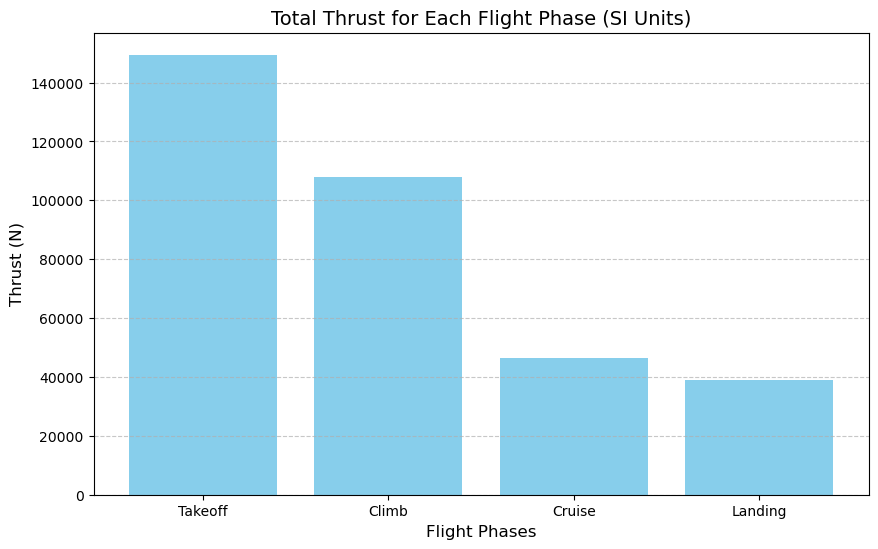

In [33]:
import math
import matplotlib.pyplot as plt
#THE CORRECT ONE 
def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine as a function of altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = 216.65 + deltaOAT_C
        P = 22632.1 * math.exp(-9.80665 * (H - 11000) / (R * T))
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = sigma * (1 + 0.2 * M ** 2) ** 3.5  # Pressure ratio
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # High Bypass Ratio Turbofan Calculation
    if theta <= TR:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M) - (3 * (theta - TR) / (1.5 + M)))

    # Special check for landing phase (low Mach number and low throttle)
    if H == 0 and M <= 0.2:  # Check if it's landing and low Mach number
        thrust = max(thrust, F0 * 0.20)  #  minimum landing thrust as 20% of sea level thrust

    # Ensure thrust is not negative
    return max(thrust, 0)  # Return thrust, ensuring it's non-negative

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.24, "TR": 1, "deltaOAT_C": 0},  # Reduced TR for realistic takeoff thrust
    "Climb": {"H": 2000, "M": 0.5, "TR": 0.96, "deltaOAT_C": -5},
    "Cruise": {"H": 12000, "M": 0.9, "TR": 0.9, "deltaOAT_C": -10},
    "Landing": {"H": 0, "M": 0.2, "TR": 0.4, "deltaOAT_C": 5},  # Adjusted TR for landing
}

# Constants
F0 = 97000  # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

# Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Mission: Passenger
Takeoff Thrust: 144753.98 N
Climb Thrust: 101327.78 N
Cruise Thrust: 55657.34 N
Landing Thrust: 36188.49 N

Mission: Aspen
Takeoff Thrust: 126313.31 N
Climb Thrust: 88419.32 N
Cruise Thrust: 53174.80 N
Landing Thrust: 31578.33 N

Mission: Napa
Takeoff Thrust: 153500.00 N
Climb Thrust: 107450.00 N
Cruise Thrust: 57537.09 N
Landing Thrust: 38375.00 N


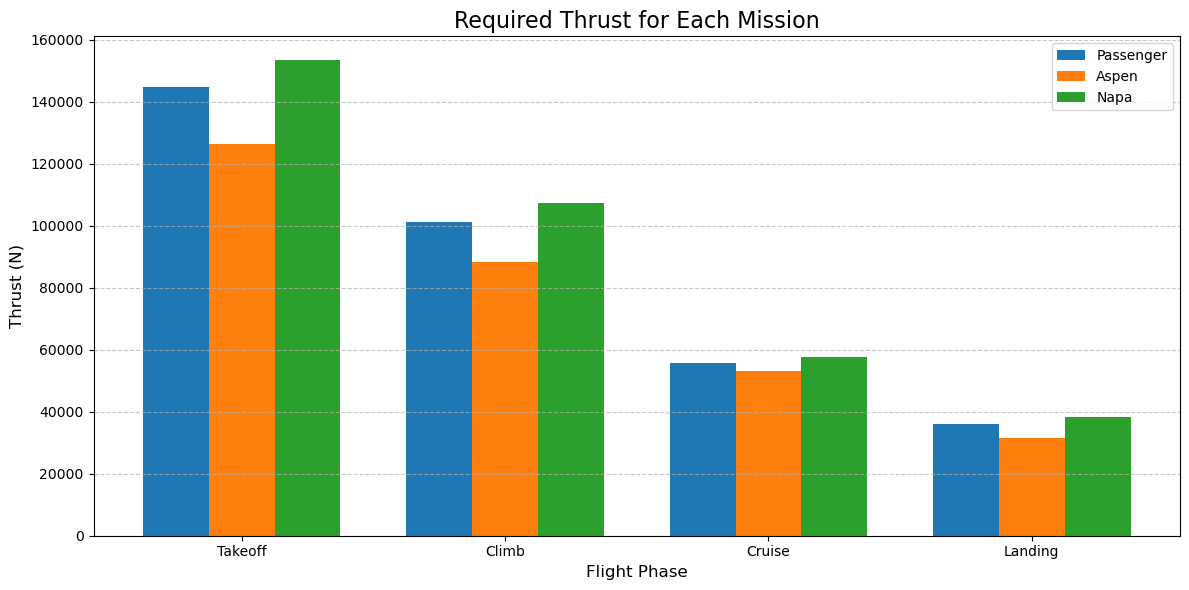

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)

# Inputs 
wing_area = 182.56  # Wing area (m²)
Cl = [1, 0.5, 0.261, 1.7]  # CL for takeoff, climb, cruise, landing
Cd = [0.09, 0.04, 0.03, 0.24]  # CD for takeoff, climb, cruise, landing
gamma_climb = 3  # Climb angle in degrees

# Mission-specific weights (in Newtons)
weights = {
    "Passenger": 471511.32,
    "Aspen": 411444.0,
    "Napa": 500000.0,
}

# Mission-specific altitudes and speeds (m and m/s)
missions = {
    "Passenger": {"altitude": [0, 3000, 12500, 0], "speeds": [80, 160, 266, 65]},
    "Aspen": {"altitude": [0, 3000, 12500, 0], "speeds": [78, 155, 260, 64]},
    "Napa": {"altitude": [0, 3000, 12000, 0], "speeds": [75, 150, 260, 60.0227]},
}

# Phases
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Functions
import math

def air_density(h):
    """ISA atmosphere model for air density."""
    # ISA constants
    rho_sl = 1.225  # Sea level standard density in kg/m³
    T0 = 288.15  # Sea level standard temperature in Kelvin
    g = 9.80665  # Gravitational acceleration in m/s²
    R = 287.05  # Specific gas constant for air in J/(kg·K)

    # Troposphere (0–11,000 m)
    if h <= 11000:
        return rho_sl * (1 - 0.0065 * h / T0) ** 4.256  # Corrected exponent for density
    # Lower stratosphere (11,000–20,000 m)
    else:
        T = 216.65  # Constant temperature in the stratosphere
        rho_11km = rho_sl * (1 - 0.0065 * 11000 / T0) ** 4.256  # Density at 11,000 m
        return rho_11km * math.exp(-g * (h - 11000) / (R * T))  # Density at altitude h

def dynamic_pressure(rho, V):
    """Calculate dynamic pressure."""
    return 0.5 * rho * V**2

def thrust_required(CD, q, S):
    """Calculate thrust required to overcome drag."""
    return CD * q * S

def climb_thrust(weight, gamma_deg, takeoff_thrust):
    """Calculate climb thrust based on typical climb performance (75% of takeoff thrust)."""
    return 0.7 * takeoff_thrust  # 70% of takeoff thrust for climb

def landing_thrust(takeoff_thrust):
    """Estimate landing thrust as a small percentage of takeoff thrust (typically 10%)."""
    return 0.25 * takeoff_thrust  # 27% of takeoff thrust for landing

# Store thrust results for visualization
thrust_results = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    W = weights[mission]
    altitudes = data["altitude"]
    speeds = data["speeds"]

    for i, phase in enumerate(phases):
        rho = air_density(altitudes[i])
        q = dynamic_pressure(rho, speeds[i])

        if phase == "Takeoff":
            # For takeoff, calculate the thrust as 30-40% of weight
            takeoff_thrust = 0.307 * W  # 30.7% of weight for takeoff thrust
            T = takeoff_thrust  # Takeoff thrust is at full value
        elif phase == "Climb":
            # For climb, use the adjusted climb thrust (75% of takeoff thrust)
            T = climb_thrust(W, gamma_climb, takeoff_thrust)  # 75% of takeoff thrust for climb
        elif phase == "Landing":
            # For landing, use a small percentage of takeoff thrust (10%)
            T = landing_thrust(takeoff_thrust)  # 10% of takeoff thrust for landing
        else:
            # For cruise, calculate thrust required to overcome drag
            T = thrust_required(Cd[i], q, wing_area)

        thrust_results[mission].append(T)
        print(f"{phase} Thrust: {T:.2f} N")

# Visualization of results 
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot each mission's thrust for all phases
for i, mission in enumerate(missions):
    ax.bar(x + i * width, thrust_results[mission], width, label=mission)

ax.set_title("Required Thrust for Each Mission", fontsize=16)
ax.set_xlabel("Flight Phase", fontsize=12)
ax.set_ylabel("Thrust (N)", fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(phases, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Mission: Passenger
Takeoff:
  Corrected Thrust: 194000.00 N
  Thrust Margin: 19540.81 N
  Fuel Burn: 204.12 kg
Climb:
  Corrected Thrust: 197123.29 N
  Thrust Margin: 45481.69 N
  Fuel Burn: 1754.08 kg
Cruise:
  Corrected Thrust: 204018.85 N
  Thrust Margin: 154284.07 N
  Fuel Burn: 34799.93 kg
Landing:
  Corrected Thrust: 194000.00 N
  Thrust Margin: 92525.16 N
  Fuel Burn: 791.50 kg

Mission: Aspen
Takeoff:
  Corrected Thrust: 194000.00 N
  Thrust Margin: 41765.72 N
  Fuel Burn: 178.11 kg
Climb:
  Corrected Thrust: 197368.62 N
  Thrust Margin: 58085.74 N
  Fuel Burn: 2146.26 kg
Cruise:
  Corrected Thrust: 214187.64 N
  Thrust Margin: 170929.83 N
  Fuel Burn: 4715.65 kg
Landing:
  Corrected Thrust: 204018.85 N
  Thrust Margin: 108003.53 N
  Fuel Burn: 1444.92 kg

Mission: Napa
Takeoff:
  Corrected Thrust: 189421.99 N
  Thrust Margin: 4421.99 N
  Fuel Burn: 220.17 kg
Climb:
  Corrected Thrust: 191677.81 N
  Thrust Margin: 43419.06 N
  Fuel Burn: 2916.02 kg
Cruise:
  Corrected Thrust: 

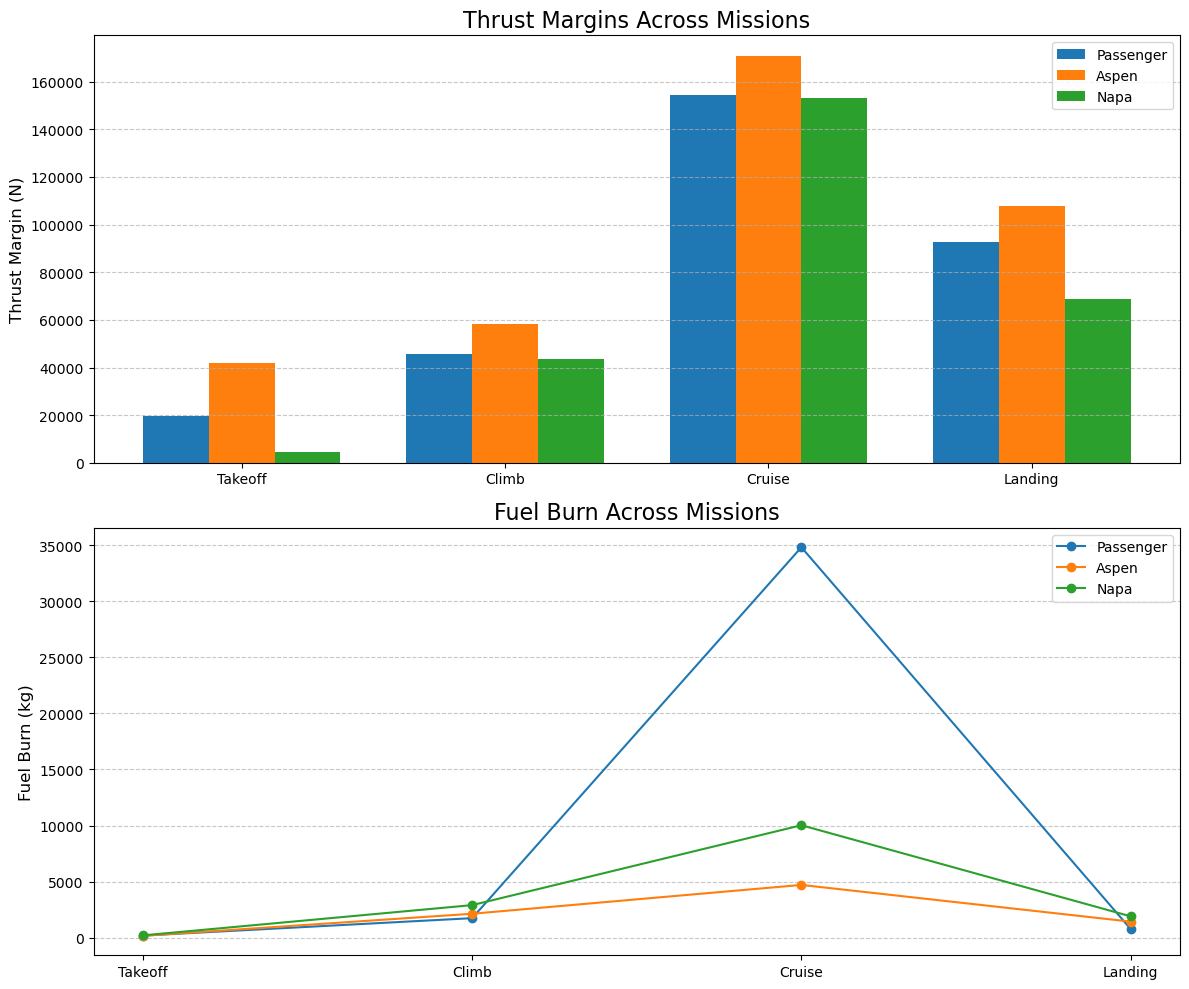

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#still checking this #needs more work 
# Constants
T_static_per_engine = 97000  # Static thrust per engine (N)
engines = 2  # Number of engines
T_static_total = T_static_per_engine * engines  # Total available thrust (N)
T0 = 288.15  # Standard sea-level temperature (K)
rho_sl = 1.225  # Sea level air density (kg/m³)
TSFC_static = 0.000013  # Static TSFC (kg/N/s)
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Mission-specific inputs
missions = {
    "Passenger": {
        "altitude": [0, 1000, 12500, 0],
        "speeds": [70, 140, 290, 60],
        "temperatures": [288.15, 281.65, 268.15, 288.15],
        "thrust_required": [174459.19, 151641.60, 49734.78, 101474.84],
        "durations": [90, 900, 55795, 600]
    },
    "Aspen": {
        "altitude": [0, 2500, 11000, 0],
        "speeds": [65, 130, 230, 55],
        "temperatures": [288.15, 281.15, 250.15, 268.15],
        "thrust_required": [152234.28, 139282.88, 43257.81, 96015.32],
        "durations": [90, 1200, 9000, 1200] 
    },
    "Napa": {
        "altitude": [0, 2000, 12500, 0],
        "speeds": [75, 150, 240, 70],
        "temperatures": [298.15, 293.15, 283.15, 298.15],
        "thrust_required": [185000.00, 148258.75, 43257.81, 120854.83],
        "durations": [90, 1500, 18000, 1200]
    },
}

# Store results 
thrust_margins = {mission: [] for mission in missions}
fuel_burns = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    thrust_required = data["thrust_required"]
    temperatures = data["temperatures"]
    durations = data["durations"]

    for i, phase in enumerate(phases):
        # Corrected Available Thrust (ISA Model)
        T_corrected = T_static_total * (temperatures[i] / T0) ** -0.7
        
        # Thrust margin
        margin = T_corrected - thrust_required[i]
        thrust_margins[mission].append(margin)
        
        # Corrected TSFC
        TSFC_corrected = TSFC_static * (temperatures[i] / T0) ** 0.5
        fuel_burn = TSFC_corrected * thrust_required[i] * durations[i]
        fuel_burns[mission].append(fuel_burn)

        print(f"{phase}:")
        print(f"  Corrected Thrust: {T_corrected:.2f} N")
        print(f"  Thrust Margin: {margin:.2f} N")
        print(f"  Fuel Burn: {fuel_burn:.2f} kg")

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# X-axis positions
x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot Thrust Margins
for i, mission in enumerate(missions):
    axs[0].bar(x + i * width, thrust_margins[mission], width, label=mission)
axs[0].set_title("Thrust Margins Across Missions", fontsize=16)
axs[0].set_ylabel("Thrust Margin (N)", fontsize=12)
axs[0].set_xticks(x + width * (len(missions) - 1) / 2)
axs[0].set_xticklabels(phases)
axs[0].legend(fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Fuel Burn
for mission in missions:
    axs[1].plot(phases, fuel_burns[mission], marker='o', label=mission)
axs[1].set_title("Fuel Burn Across Missions", fontsize=16)
axs[1].set_ylabel("Fuel Burn (kg)", fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46  # Operating Empty Weight (lbs)
MFW = 50000  # Maximum Fuel Weight (lbs)
MZFW = MTOW - MFW  # Maximum Zero Fuel Weight
MPL = MZFW - OEW  # Maximum Payload (lbs)

# Breguet Range Function with Updated Formula
def breguet_range(Wi, Wf, V, LbyD, CT):
    return V * (LbyD / CT) * np.log(Wi / Wf) / 6076  # Range in nmi

# Payload-Range Diagram Function
def payload_range_diagram(CT_hr, LbyD, V_knots):
    CT = CT_hr / 3600  # Convert TSFC to per second
    V = V_knots * 1.68781  # Convert knots to ft/s
    
    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = MPL

    # Point B: Max Payload, range with full fuel burned
    Wi_B = OEW + MPL + MFW
    Wf_B = OEW + MPL
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = MPL

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0

    # Point D: Partial Payload, range with max fuel burned
    Payload_D = MPL / 2
    Wi_D = OEW + Payload_D + MFW
    Wf_D = OEW + Payload_D
    R_D = breguet_range(Wi_D, Wf_D, V, LbyD, CT)

    # Plot the Payload-Range Diagram
    ranges = [R_A, R_B, R_D, R_C]
    payloads = [Payload_A, Payload_B, Payload_D, Payload_C]

    #weight = [MTOW, OEW, MFW, MZFW]
    #range_ = [0, 6000, , ]
    #plt.plot(range_, weight)
    
    plt.figure(figsize=(10, 6))
    plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
    plt.title("Payload-Range Diagram", fontsize=16)
    plt.xlabel("Range (nmi)", fontsize=14)
    plt.ylabel("Payload (lbs)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # points on the diagram 
    plt.annotate(f"A (0, {int(Payload_A)})", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"B ({int(R_B)}, {int(Payload_B)})", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"D ({int(R_D)}, {int(Payload_D)})", (R_D, Payload_D), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"C ({int(R_C)}, {int(Payload_C)})", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return R_B, R_D, R_C
# Interactive Sliders to optimise parameters 
interact(payload_range_diagram, 
         CT_hr=(0.3, 0.6, 0.01),  # Select CT directly as lb/lbf/hr
         LbyD=(9, 12, 0.1), 
         V_knots=(450, 600, 5));


interactive(children=(FloatSlider(value=0.44, description='CT_hr', max=0.6, min=0.3, step=0.01), FloatSlider(v…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46  # Operating Empty Weight (lbs)
MFW = 50000  # Maximum Fuel Weight (lbs)
MZFW = MTOW - MFW  # Maximum Zero Fuel Weight
MPL = MZFW - OEW  # Maximum Payload (lbs)
RESERVE_FUEL = 3200  # Reserve Fuel (lbs)

# Breguet Range Function with Updated Formula
def breguet_range(Wi, Wf, V, LbyD, CT):
    return V * (LbyD / CT) * np.log(Wi / Wf) / 6076  # Range in nmi

# Payload-Range Diagram Function
def payload_range_diagram(CT_hr, LbyD, V_knots):
    CT = CT_hr / 3600  # Convert TSFC to per second
    V = V_knots * 1.68781  # Convert knots to ft/s
    
    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = MPL
    Fuel_A = 0  # No fuel burned at zero range
    Reserve_Fuel_A = RESERVE_FUEL  # Reserve fuel remains
    MTOW_A = OEW + Payload_A + Fuel_A + Reserve_Fuel_A  # MTOW at point A

    # Point B: Max Payload, range with full fuel burned (excluding reserve fuel)
    Wi_B = OEW + MPL + MFW
    Wf_B = OEW + MPL + RESERVE_FUEL  # Reserve fuel remains
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = MPL
    Fuel_B = MFW - RESERVE_FUEL  # Usable fuel
    Reserve_Fuel_B = RESERVE_FUEL
    MTOW_B = OEW + Payload_B + Fuel_B + Reserve_Fuel_B  # MTOW at point B

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW + RESERVE_FUEL  # Reserve fuel remains
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0
    Fuel_C = MFW - RESERVE_FUEL  # Usable fuel
    Reserve_Fuel_C = RESERVE_FUEL
    MTOW_C = OEW + Payload_C + Fuel_C + Reserve_Fuel_C  # MTOW at point C

    # Point D: Partial Payload, range with max fuel burned
    Payload_D = MPL / 2
    Wi_D = OEW + Payload_D + MFW
    Wf_D = OEW + Payload_D + RESERVE_FUEL  # Reserve fuel remains
    R_D = breguet_range(Wi_D, Wf_D, V, LbyD, CT)
    Fuel_D = MFW - RESERVE_FUEL  # Usable fuel
    Reserve_Fuel_D = RESERVE_FUEL
    MTOW_D = OEW + Payload_D + Fuel_D + Reserve_Fuel_D  # MTOW at point D

    # Plot the Payload-Range Diagram
    ranges = [R_A, R_B, R_D, R_C]
    payloads = [Payload_A, Payload_B, Payload_D, Payload_C]

    plt.figure(figsize=(12, 8))
    plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
    plt.title("Payload-Range Diagram with Weight Breakdown", fontsize=16)
    plt.xlabel("Range (nmi)", fontsize=14)
    plt.ylabel("Payload (lbs)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate points on the diagram
    plt.annotate(f"A (0, {int(Payload_A)})", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"B ({int(R_B)}, {int(Payload_B)})", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"D ({int(R_D)}, {int(Payload_D)})", (R_D, Payload_D), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"C ({int(R_C)}, {int(Payload_C)})", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

    # Add weight breakdown table
    weight_data = [
        ["Point", "Payload (lbs)", "Fuel (lbs)", "Reserve Fuel (lbs)", "Empty Weight (lbs)", "MTOW (lbs)"],
        ["A", Payload_A, Fuel_A, Reserve_Fuel_A, OEW, MTOW_A],
        ["B", Payload_B, Fuel_B, Reserve_Fuel_B, OEW, MTOW_B],
        ["D", Payload_D, Fuel_D, Reserve_Fuel_D, OEW, MTOW_D],
        ["C", Payload_C, Fuel_C, Reserve_Fuel_C, OEW, MTOW_C]
    ]

    # Display weight breakdown as a table

    
    plt.table(cellText=weight_data, loc='bottom', colLabels=None, cellLoc='center', bbox=[0.1, -0.5, 0.8, 0.5])

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return R_B, R_D, R_C

# Interactive Sliders to optimise parameters 
interact(payload_range_diagram, 
         CT_hr=(0.3, 0.6, 0.01),  # Select CT directly as lb/lbf.hr
         LbyD=(9, 12, 0.1), 
         V_knots=(450, 600, 5));

interactive(children=(FloatSlider(value=0.44, description='CT_hr', max=0.6, min=0.3, step=0.01), FloatSlider(v…

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46  # Operating Empty Weight (lbs)
MFW = 50000  # Maximum Fuel Weight (lbs)
MZFW = MTOW - MFW  # Maximum Zero Fuel Weight
MPL = MZFW - OEW  # Maximum Payload (lbs)
RESERVE_FUEL = 3200  # Reserve Fuel (lbs)

# Breguet Range Function with Updated Formula
def breguet_range(Wi, Wf, V, LbyD, CT):
    return V * (LbyD / CT) * np.log(Wi / Wf) / 6076  # Range in nmi

# Payload-Range Diagram Function
def payload_range_diagram(CT_hr, LbyD, V_knots):
    CT = CT_hr / 3600  # Convert TSFC to per second
    V = V_knots * 1.68781  # Convert knots to ft/s
    
    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = MPL
    Fuel_A = MFW  # Full fuel at zero range
    Reserve_Fuel_A = RESERVE_FUEL  # Reserve fuel remains
    MTOW_A = OEW + Payload_A + Fuel_A + Reserve_Fuel_A  # MTOW at point A

    # Point B: Max Payload, range with full fuel burned (excluding reserve fuel)
    Wi_B = OEW + MPL + MFW  # Initial weight (max payload + max fuel)
    Wf_B = OEW + MPL + RESERVE_FUEL  # Final weight (reserve fuel remains)
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = MPL
    Fuel_B = MFW - (Wi_B - Wf_B)  # Fuel burned = Wi_B - Wf_B
    Reserve_Fuel_B = RESERVE_FUEL
    MTOW_B = OEW + Payload_B + Fuel_B + Reserve_Fuel_B  # MTOW at point B

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW + RESERVE_FUEL  # Reserve fuel remains
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0
    Fuel_C = MFW - (Wi_C - Wf_C)  # Fuel burned = Wi_C - Wf_C
    Reserve_Fuel_C = RESERVE_FUEL
    MTOW_C = OEW + Payload_C + Fuel_C + Reserve_Fuel_C  # MTOW at point C

    # Point D: Partial Payload, range with max fuel burned
    Payload_D = MPL / 2
    Wi_D = OEW + Payload_D + MFW
    Wf_D = OEW + Payload_D + RESERVE_FUEL  # Reserve fuel remains
    R_D = breguet_range(Wi_D, Wf_D, V, LbyD, CT)
    Fuel_D = MFW - (Wi_D - Wf_D)  # Fuel burned = Wi_D - Wf_D
    Reserve_Fuel_D = RESERVE_FUEL
    MTOW_D = OEW + Payload_D + Fuel_D + Reserve_Fuel_D  # MTOW at point D

    # Plot the Payload-Range Diagram
    ranges = [R_A, R_B, R_D, R_C]
    payloads = [Payload_A, Payload_B, Payload_D, Payload_C]

    plt.figure(figsize=(12, 8))
    plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
    plt.title("Payload-Range Diagram with Weight Breakdown", fontsize=16)
    plt.xlabel("Range (nmi)", fontsize=14)
    plt.ylabel("Payload (lbs)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate points on the diagram
    plt.annotate(f"A (0, {int(Payload_A)})", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"B ({int(R_B)}, {int(Payload_B)})", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"D ({int(R_D)}, {int(Payload_D)})", (R_D, Payload_D), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"C ({int(R_C)}, {int(Payload_C)})", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

    # Add weight breakdown table
    weight_data = [
        ["Point", "Payload (lbs)", "Fuel (lbs)", "Reserve Fuel (lbs)", "Empty Weight (lbs)", "MTOW (lbs)"],
        ["A", Payload_A, Fuel_A, Reserve_Fuel_A, OEW, MTOW_A],
        ["B", Payload_B, Fuel_B, Reserve_Fuel_B, OEW, MTOW_B],
        ["D", Payload_D, Fuel_D, Reserve_Fuel_D, OEW, MTOW_D],
        ["C", Payload_C, Fuel_C, Reserve_Fuel_C, OEW, MTOW_C]
    ]

    # Display weight breakdown as a table
    plt.table(cellText=weight_data, loc='bottom', colLabels=None, cellLoc='center', bbox=[0.1, -0.5, 0.8, 0.5])

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return R_B, R_D, R_C

# Interactive Sliders to optimise parameters 
interact(payload_range_diagram, 
         CT_hr=(0.3, 0.6, 0.01),  # Select CT directly as lb/lbf/hr
         LbyD=(9, 15, 0.1), 
         V_knots=(450, 600, 5));

interactive(children=(FloatSlider(value=0.44, description='CT_hr', max=0.6, min=0.3, step=0.01), FloatSlider(v…

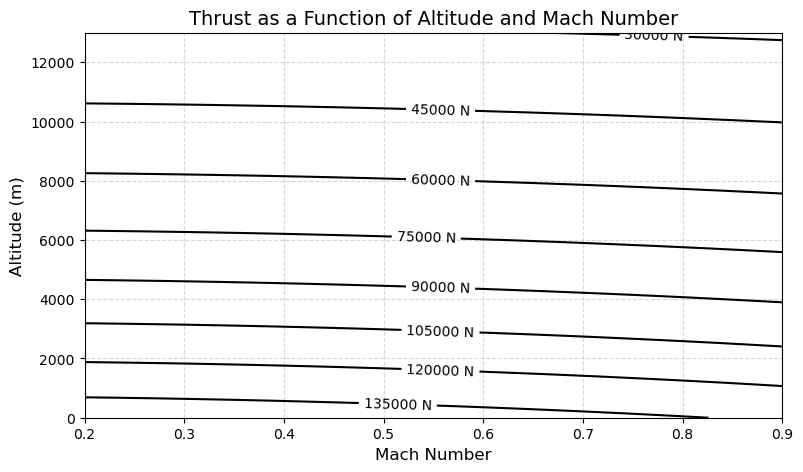

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m^3)
T_sl = 144884.78  # Sea-level thrust (N) for the engine
gamma = 1.4     # Ratio of specific heats for air
R = 287.05      # Specific gas constant for air (J/kg·K)
T0 = 288.15     # Sea-level standard temperature (K)
L = 0.0065      # Temperature lapse rate (K/m)
P0 = 101325     # Sea-level pressure (Pa)
g = 9.81        # Gravity (m/s^2)

# Altitude and Mach ranges
altitudes = np.linspace(0, 13000, 50)  # Altitude range: 0 to 12.5 km
mach_numbers = np.linspace(0.2, 0.9, 50)  # Mach range: 0.2 to 0.9

# Function to calculate air density at a given altitude (ISA model)
def air_density(altitude):
    if altitude < 11000:  # Troposphere
        T = T0 - L * altitude
        P = P0 * (1 - L * altitude / T0) ** (g / (R * L))
        rho = P / (R * T)
    else:  # Simplified model for stratosphere
        T = T0 - L * 11000
        P = P0 * (1 - L * 11000 / T0) ** (g / (R * L)) * np.exp(-g * (altitude - 11000) / (R * T))
        rho = P / (R * T)
    return rho

# Function to calculate thrust lapse with altitude and Mach
def thrust_lapse(altitude, mach):
    rho = air_density(altitude)
    thrust = T_sl * (rho / rho_sl) * (1 - 0.1 * mach**2)  # Simplified thrust lapse model
    return max(thrust, 0)  # Thrust cannot be negative

# Calculate thrust over altitude and Mach grid
thrust_values = np.zeros((len(altitudes), len(mach_numbers)))

for i, alt in enumerate(altitudes):
    for j, mach in enumerate(mach_numbers):
        thrust_values[i, j] = thrust_lapse(alt, mach)

# Plot the contour plot
X, Y = np.meshgrid(mach_numbers, altitudes)

plt.figure(figsize=(9, 5))
cp = plt.contour(X, Y, thrust_values, levels=10, colors='black', linestyles='solid')
plt.clabel(cp, inline=True, fontsize=10, fmt="%.0f N")  #  labels to contours
plt.title("Thrust as a Function of Altitude and Mach Number", fontsize=14)
plt.xlabel("Mach Number", fontsize=12)
plt.ylabel("Altitude (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [92]:
# Takeoff distance calculation 

# Known constants
W0 = 471672.55  # Maximum takeoff weight (N)
V_stall = 60 #58.188   Stall speed (m/s)
V_LOF = 1.1 * V_stall  # Liftoff speed (m/s)
V_2 = 1.2 * V_stall  # Climb-out speed (m/s)
print (V_2)
T = 149451.43  # Takeoff thrust (N)
mu = 0.02  # Friction coefficient
rho = 1.225  # Sea level air density (kg/m^3)
#S = 164.9  # Wing area (m^2) Try to keep the value global and do not overwrite it
C_D = 0.20  # Drag coefficient
C_L = 1.0  # Lift coefficient
C_D0 = 0.017  # Zero-lift drag coefficient takeoff, flaps geared up
C_Lmax = 1.9  # Maximum lift coefficient takeoff, flaps geared up
g = 9.81  # Gravitational acceleration (m/s^2)
Lambda = 0.161  # Taper ratio
h = 10.668  # Height at which takeoff is completed (m)
A = 4.5  # Aspect ratio

T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)
mu_prime = mu + (0.72 * (C_D0 / C_Lmax))  # Effective friction coefficient

# Ground run distance (x_g in meters)
x_g = ((V_LOF**2) / (2 * g)) / ((T_bar / W0) - mu_prime)

# Climb angle (gamma_LOF in radians)
gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

# Air run distance (x_a in meters)
x_a = ((V_LOF**2) / (2 * g)) + (h / gamma_lof)

# Total takeoff distance (meters)
Takeoff_distance = x_g + x_a

# Print results
print("Takeoff Distance Calculations:")
print(f"Stall Speed (V_stall): {V_stall:.2f} m/s")
print(f"Liftoff Speed (V_LOF): {V_LOF:.2f} m/s")
print(f"Climb-out Speed (V_2): {V_2:.2f} m/s")
print(f"Average Thrust (T_bar): {T_bar:.2f} N")
print(f"Effective Friction Coefficient (mu_prime): {mu_prime:.4f}")
print(f"Ground Run Distance (x_g): {x_g:.2f} m")
print(f"Air Run Distance (x_a): {x_a:.2f} m")
print(f"Total Takeoff Distance: {Takeoff_distance:.2f} m")


72.0
Takeoff Distance Calculations:
Stall Speed (V_stall): 60.00 m/s
Liftoff Speed (V_LOF): 66.00 m/s
Climb-out Speed (V_2): 72.00 m/s
Average Thrust (T_bar): 139026.47 N
Effective Friction Coefficient (mu_prime): 0.0264
Ground Run Distance (x_g): 827.47 m
Air Run Distance (x_a): 308.15 m
Total Takeoff Distance: 1135.62 m


In [17]:
import math

def isa_temperature(altitude):
    """
    Calculate the ambient temperature at a given altitude using the ISA model.

    Parameters:
        altitude (float): Altitude in feet.

    Returns:
        float: Ambient temperature in Kelvin.
    """
    # ISA constants
    T0 = 288.15  # Sea level standard temperature in Kelvin
    lapse_rate = -0.0065  # Temperature lapse rate in K/m
    altitude_m = altitude * 0.3048  # Convert altitude from feet to meters

    # Calculate ambient temperature
    if altitude_m <= 11000:  # Troposphere (0–11,000 m)
        T = T0 + lapse_rate * altitude_m
    else:
        # For simplicity, assume constant temperature in the stratosphere
        T = 216.65  # Temperature at 11,000 m in Kelvin

    return T

def calculate_corrected_tsfc(tsfc0, altitude, M, n):
    """
    Calculate the corrected TSFC using the formula:
    TSFC = TSFC0 * sqrt(theta) * (1 + M)^n

    Parameters:
        tsfc0 (float): Baseline TSFC at sea level static conditions.
        altitude (float): Altitude in feet.
        M (float): Mach number.
        n (float): Empirical constant (typically between 0.2 and 0.5).

    Returns:
        float: Corrected TSFC.
    """
    # Standard sea level temperature in Kelvin
    T0 = 288.15

    # Calculate ambient temperature using the ISA model
    T = isa_temperature(altitude)

    # Calculate temperature ratio (theta)
    theta = T / T0

    # Calculate corrected TSFC
    corrected_tsfc = tsfc0 * math.sqrt(theta) * ((1 + M) ** n)

    return corrected_tsfc

# Example usage
if __name__ == "__main__":
    # Input parameters
    tsfc0 = 0.35  # Baseline TSFC in lb/lbf·hr
    altitude = 40000  # Altitude in feet
    M = 0.9  # Mach number
    n = 0.8  # Empirical constant

    # Calculate corrected TSFC
    corrected_tsfc = calculate_corrected_tsfc(tsfc0, altitude, M, n)

    # Print the result
    print(f"Corrected TSFC at {altitude} ft: {corrected_tsfc:.4f} lb/lbf·hr")

Corrected TSFC at 40000 ft: 0.5072 lb/lbf·hr


In [63]:

import math
# Landing Distance Calculation 
W_landing = 253488.33 # lalnding weight in Newton 
#S = 164.5 # wing area in m
rho = 1.225 # density at sea level in kg/m^3
C_Lmax = 2.1 # maximum wing lift coefficient, landing flaps gear up
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
V_stall = ((2*W_landing)/(S*rho*C_Lmax))**0.5
print (V_stall)
V2 = 1.3 *V_stall # Approach speed (m/s)
n = 1.2  # Load factor
V_TD = 1.15*V_stall # Touchdown speed (m/s)
print (V_TD)
a_mean = 2  # Mean deceleration (m/s^2)

def calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean):
    # Convert angles from degrees to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (9.81 * (n - 1))  # g = 9.81 m/s^2
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (9.81 * (n - 1))

    # Ground run distance
    x_g = (V_TD ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

    # Convert values to feet and seconds 
def display_results(result):
    conversion_factors = {
        "m_to_ft": 3.28084,
        "m_to_ft_min": 3.28084 / 60,
    }
    
    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")
        else:  # For total values
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")

# Calculate and display landing distance with units
result = calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean)
display_results(result)



32.47304784360391
37.34400502014449
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 6.11 s
Rotation Distance (x2): 47.54 m (155.96 ft)
Rotation Time (t2): 1.13 s
Ground Run Distance (xg): 348.64 m (1143.84 ft)
Total Landing Distance: 653.78 m (2144.94 ft)


In [90]:
import math
# Takeoff disntances at different Airports corrected for temperature and density 
# Function to calculate air density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Minimum temperature ~200K
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

# Function to calculate adjusted takeoff distance
def adjusted_takeoff_distance(altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate the takeoff distance adjusted for altitude, temperature, wind, and slope.
    """
    # Constants
    W0 =471672.55   # Maximum takeoff weight (N)
    V_stall = 60  # Stall speed (m/s)
    T = 149451.43 # Takeoff thrust (N)
    mu = 0.02  # Friction coefficient
    S = 184.03  # Wing area (m^2)
    C_D0 = 0.017  # Zero-lift drag coefficient
    C_Lmax = 1.9  # Maximum lift coefficient
    g = 9.81  # Gravitational acceleration (m/s^2)
    Lambda = 0.161  # Taper ratio
    h = 10.668  # Height at which takeoff is completed (m)
    A = 4.5  # Aspect ratio

    # Adjusted air density
    rho = air_density(altitude_ft, temperature_c)

    # Adjusted liftoff speed
    V_LOF = 1.1 * V_stall * math.sqrt(1.225 / rho)
    V_2 = 1.2 * V_stall * math.sqrt(1.225 / rho)
    V_GS = V_LOF - wind_speed  # Adjusted ground speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = g * math.cos(theta_slope)

    # Average thrust
    T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)

    # Effective friction coefficient
    mu_prime = mu + (0.72 * (C_D0 / C_Lmax))

    # Ground run distance (x_g in meters)
    x_g = ((V_GS**2) / (2 * g_eff)) / ((T_bar / W0) - mu_prime)

    # Climb angle (gamma_LOF in radians)
    gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

    # Air run distance (x_a in meters)
    x_a = ((V_LOF**2) / (2 * g_eff)) + (h / gamma_lof)

    # Total takeoff distance (meters)
    takeoff_distance = x_g + x_a

    return takeoff_distance

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Calculate and display takeoff distances for each mission
for mission, params in missions.items():
    takeoff_dist = adjusted_takeoff_distance(
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"{mission}: Adjusted Takeoff Distance = {takeoff_dist:.2f} meters")


Passenger Mission: Adjusted Takeoff Distance = 1166.48 meters
Aspen Economic Mission: Adjusted Takeoff Distance = 1247.68 meters
Napa Economic Mission: Adjusted Takeoff Distance = 1594.86 meters


In [94]:
# landing disntances at different Airports corrected for temperature and density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Ensure realistic temperature
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

def adjusted_landing_distance(W_landing, S, C_Lmax, h_ob, h_r, gamma_deg, n, a_mean, altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate landing distance adjusted for altitude, temperature, wind, and slope.
    """
    # Air density
    rho_sea_level = 1.225  # Sea level air density (kg/m³)
    rho = air_density(altitude_ft, temperature_c)  # Adjusted air density

    # Adjusted approach speed
    V_stall = math.sqrt((2 * W_landing) / (S * rho * C_Lmax))
    V2 = 1.3 * V_stall * math.sqrt(rho_sea_level / rho)  # Effective approach speed
    V_TD = 1.15 * V_stall * math.sqrt(rho_sea_level / rho)  # Effective touchdown speed
    V_ground = V2 - wind_speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = 9.81 * math.cos(theta_slope)

    # Convert descent angle to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (g_eff * (n - 1))
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (g_eff * (n - 1))

    # Ground run distance
    x_g = (V_ground ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

def display_results(result):
    """
    Display landing distance results in meters and feet.
    """
    conversion_factors = {
        "m_to_ft": 3.28084,
    }

    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Landing weight and constants
W_landing = 253488.33  # Landing weight in Newtons
S = 186.89  # Wing area in m²
C_Lmax = 2.1 # Maximum lift coefficient
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
n = 1.2  # Load factor
a_mean = 2  # Mean deceleration (m/s²)

# Calculate and display landing distances for each mission
for mission, params in missions.items():
    result = adjusted_landing_distance(
        W_landing, S, C_Lmax, h_ob, h_r, gamma_deg, n, a_mean,
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"\n{mission}:")
    display_results(result)



Passenger Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 5.94 s
Rotation Distance (x2): 50.37 m (165.27 ft)
Rotation Time (t2): 1.16 s
Ground Run Distance (xg): 472.11 m (1548.92 ft)
Total Landing Distance: 780.08 m (2559.32 ft)

Aspen Economic Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 4.95 s
Rotation Distance (x2): 72.50 m (237.87 ft)
Rotation Time (t2): 1.39 s
Ground Run Distance (xg): 555.41 m (1822.21 ft)
Total Landing Distance: 885.51 m (2905.21 ft)

Napa Economic Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 4.52 s
Rotation Distance (x2): 86.97 m (285.33 ft)
Rotation Time (t2): 1.52 s
Ground Run Distance (xg): 902.97 m (2962.50 ft)
Total Landing Distance: 1247.53 m (4092.96 ft)


In [93]:
# Takeoff distance calculation for multiple missions

# Known constants
V_stall = 60  # Stall speed (m/s)
V_LOF = 1.1 * V_stall  # Liftoff speed (m/s)
V_2 = 1.2 * V_stall  # Climb-out speed (m/s)
T = 149451.43  # Takeoff thrust (N)
mu = 0.02  # Friction coefficient
rho = 1.225  # Sea level air density (kg/m^3)
C_D = 0.20  # Drag coefficient
C_L = 1.0  # Lift coefficient
C_D0 = 0.017  # Zero-lift drag coefficient takeoff, flaps geared up
C_Lmax = 1.9  # Maximum lift coefficient takeoff, flaps geared up
g = 9.81  # Gravitational acceleration (m/s^2)
Lambda = 0.161  # Taper ratio
h = 10.668  # Height at which takeoff is completed (m)
A = 4.5  # Aspect ratio

# Function to calculate takeoff distance
def calculate_takeoff_distance(W0):
    # Average thrust (N)
    T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T

    # Effective friction coefficient
    mu_prime = mu + (0.72 * (C_D0 / C_Lmax))

    # Ground run distance (x_g in meters)
    x_g = ((V_LOF**2) / (2 * g)) / ((T_bar / W0) - mu_prime)

    # Climb angle (gamma_LOF in radians)
    gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

    # Air run distance (x_a in meters)
    x_a = ((V_LOF**2) / (2 * g)) + (h / gamma_lof)

    # Total takeoff distance (meters)
    Takeoff_distance = x_g + x_a

    return Takeoff_distance, x_g, x_a, T_bar, mu_prime

# MTOW for the missions
missions = {
    "Aspen": 411444.0,  # MTOW for Aspen mission (N)
    "Napa": 500000.0,   # MTOW for Napa mission (N)
}

# Calculate and print results for each mission
for mission, W0 in missions.items():
    Takeoff_distance, x_g, x_a, T_bar, mu_prime = calculate_takeoff_distance(W0)
    
    print(f"\nTakeoff Distance Calculations for {mission}:")
    print(f"Maximum Takeoff Weight (W0): {W0:.2f} N")
    print(f"Stall Speed (V_stall): {V_stall:.2f} m/s")
    print(f"Liftoff Speed (V_LOF): {V_LOF:.2f} m/s")
    print(f"Climb-out Speed (V_2): {V_2:.2f} m/s")
    print(f"Average Thrust (T_bar): {T_bar:.2f} N")
    print(f"Effective Friction Coefficient (mu_prime): {mu_prime:.4f}")
    print(f"Ground Run Distance (x_g): {x_g:.2f} m")
    print(f"Air Run Distance (x_a): {x_a:.2f} m")
    print(f"Total Takeoff Distance: {Takeoff_distance:.2f} m")


Takeoff Distance Calculations for Aspen:
Maximum Takeoff Weight (W0): 411444.00 N
Stall Speed (V_stall): 60.00 m/s
Liftoff Speed (V_LOF): 66.00 m/s
Climb-out Speed (V_2): 72.00 m/s
Average Thrust (T_bar): 139026.47 N
Effective Friction Coefficient (mu_prime): 0.0264
Ground Run Distance (x_g): 712.84 m
Air Run Distance (x_a): 287.59 m
Total Takeoff Distance: 1000.43 m

Takeoff Distance Calculations for Napa:
Maximum Takeoff Weight (W0): 500000.00 N
Stall Speed (V_stall): 60.00 m/s
Liftoff Speed (V_LOF): 66.00 m/s
Climb-out Speed (V_2): 72.00 m/s
Average Thrust (T_bar): 139026.47 N
Effective Friction Coefficient (mu_prime): 0.0264
Ground Run Distance (x_g): 882.39 m
Air Run Distance (x_a): 320.05 m
Total Takeoff Distance: 1202.43 m


In [95]:
import math

# Function to calculate air density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Minimum temperature ~200K
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

# Function to calculate adjusted takeoff distance
def adjusted_takeoff_distance(W0, altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate the takeoff distance adjusted for altitude, temperature, wind, and slope.
    """
    # Constants
    V_stall = 60  # Stall speed (m/s)
    T = 149451.43  # Takeoff thrust (N)
    mu = 0.02  # Friction coefficient
    S = 184.03  # Wing area (m^2)
    C_D0 = 0.017  # Zero-lift drag coefficient
    C_Lmax = 1.9  # Maximum lift coefficient
    g = 9.81  # Gravitational acceleration (m/s^2)
    Lambda = 0.161  # Taper ratio
    h = 10.668  # Height at which takeoff is completed (m)
    A = 4.5  # Aspect ratio

    # Adjusted air density
    rho = air_density(altitude_ft, temperature_c)

    # Adjusted liftoff speed
    V_LOF = 1.1 * V_stall * math.sqrt(1.225 / rho)
    V_2 = 1.2 * V_stall * math.sqrt(1.225 / rho)
    V_GS = V_LOF - wind_speed  # Adjusted ground speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = g * math.cos(theta_slope)

    # Average thrust
    T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)

    # Effective friction coefficient
    mu_prime = mu + (0.72 * (C_D0 / C_Lmax))

    # Ground run distance (x_g in meters)
    x_g = ((V_GS**2) / (2 * g_eff)) / ((T_bar / W0) - mu_prime)

    # Climb angle (gamma_LOF in radians)
    gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

    # Air run distance (x_a in meters)
    x_a = ((V_LOF**2) / (2 * g_eff)) + (h / gamma_lof)

    # Total takeoff distance (meters)
    takeoff_distance = x_g + x_a

    return takeoff_distance

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"W0": 471672.55, "altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"W0": 411444.0, "altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"W0": 500000.0, "altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Calculate and display takeoff distances for each mission
for mission, params in missions.items():
    takeoff_dist = adjusted_takeoff_distance(
        params["W0"], params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"{mission}: Adjusted Takeoff Distance = {takeoff_dist:.2f} meters")

Passenger Mission: Adjusted Takeoff Distance = 1166.48 meters
Aspen Economic Mission: Adjusted Takeoff Distance = 1104.20 meters
Napa Economic Mission: Adjusted Takeoff Distance = 1686.96 meters


In [96]:
import math

# Function to calculate air density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Minimum temperature ~200K
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

# Function to calculate adjusted takeoff distance and additional parameters
def adjusted_takeoff_distance(W0, altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate the takeoff distance adjusted for altitude, temperature, wind, and slope.
    Also returns liftoff speed, stall speed, climb-out speed, and effective friction coefficient.
    """
    # Constants
    V_stall = 60  # Stall speed (m/s)
    T = 149451.43  # Takeoff thrust (N)
    mu = 0.02  # Friction coefficient
    S = 184.03  # Wing area (m^2)
    C_D0 = 0.017  # Zero-lift drag coefficient
    C_Lmax = 1.9  # Maximum lift coefficient
    g = 9.81  # Gravitational acceleration (m/s^2)
    Lambda = 0.161  # Taper ratio
    h = 10.668  # Height at which takeoff is completed (m)
    A = 4.5  # Aspect ratio

    # Adjusted air density
    rho = air_density(altitude_ft, temperature_c)

    # Adjusted stall speed
    V_stall_adj = V_stall * math.sqrt(1.225 / rho)

    # Adjusted liftoff speed
    V_LOF = 1.1 * V_stall_adj

    # Adjusted climb-out speed
    V_2 = 1.2 * V_stall_adj

    # Adjusted ground speed
    V_GS = V_LOF - wind_speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = g * math.cos(theta_slope)

    # Average thrust
    T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)

    # Effective friction coefficient
    mu_prime = mu + (0.72 * (C_D0 / C_Lmax))

    # Ground run distance (x_g in meters)
    x_g = ((V_GS**2) / (2 * g_eff)) / ((T_bar / W0) - mu_prime)

    # Climb angle (gamma_LOF in radians)
    gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

    # Air run distance (x_a in meters)
    x_a = ((V_LOF**2) / (2 * g_eff)) + (h / gamma_lof)

    # Total takeoff distance (meters)
    takeoff_distance = x_g + x_a

    return takeoff_distance, V_stall_adj, V_LOF, V_2, mu_prime

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"W0": 471672.55, "altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"W0": 411444.0, "altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"W0": 500000.0, "altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Calculate and display takeoff distances and additional parameters for each mission
for mission, params in missions.items():
    takeoff_dist, V_stall_adj, V_LOF, V_2, mu_prime = adjusted_takeoff_distance(
        params["W0"], params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"\n{mission}:")
    print(f"  Adjusted Takeoff Distance = {takeoff_dist:.2f} meters")
    print(f"  Adjusted Stall Speed (V_stall) = {V_stall_adj:.2f} m/s")
    print(f"  Liftoff Speed (V_LOF) = {V_LOF:.2f} m/s")
    print(f"  Climb-out Speed (V_2) = {V_2:.2f} m/s")
    print(f"  Effective Friction Coefficient (mu_prime) = {mu_prime:.4f}")


Passenger Mission:
  Adjusted Takeoff Distance = 1166.48 meters
  Adjusted Stall Speed (V_stall) = 60.88 m/s
  Liftoff Speed (V_LOF) = 66.96 m/s
  Climb-out Speed (V_2) = 73.05 m/s
  Effective Friction Coefficient (mu_prime) = 0.0264

Aspen Economic Mission:
  Adjusted Takeoff Distance = 1104.20 meters
  Adjusted Stall Speed (V_stall) = 66.68 m/s
  Liftoff Speed (V_LOF) = 73.35 m/s
  Climb-out Speed (V_2) = 80.01 m/s
  Effective Friction Coefficient (mu_prime) = 0.0264

Napa Economic Mission:
  Adjusted Takeoff Distance = 1686.96 meters
  Adjusted Stall Speed (V_stall) = 69.78 m/s
  Liftoff Speed (V_LOF) = 76.76 m/s
  Climb-out Speed (V_2) = 83.74 m/s
  Effective Friction Coefficient (mu_prime) = 0.0264


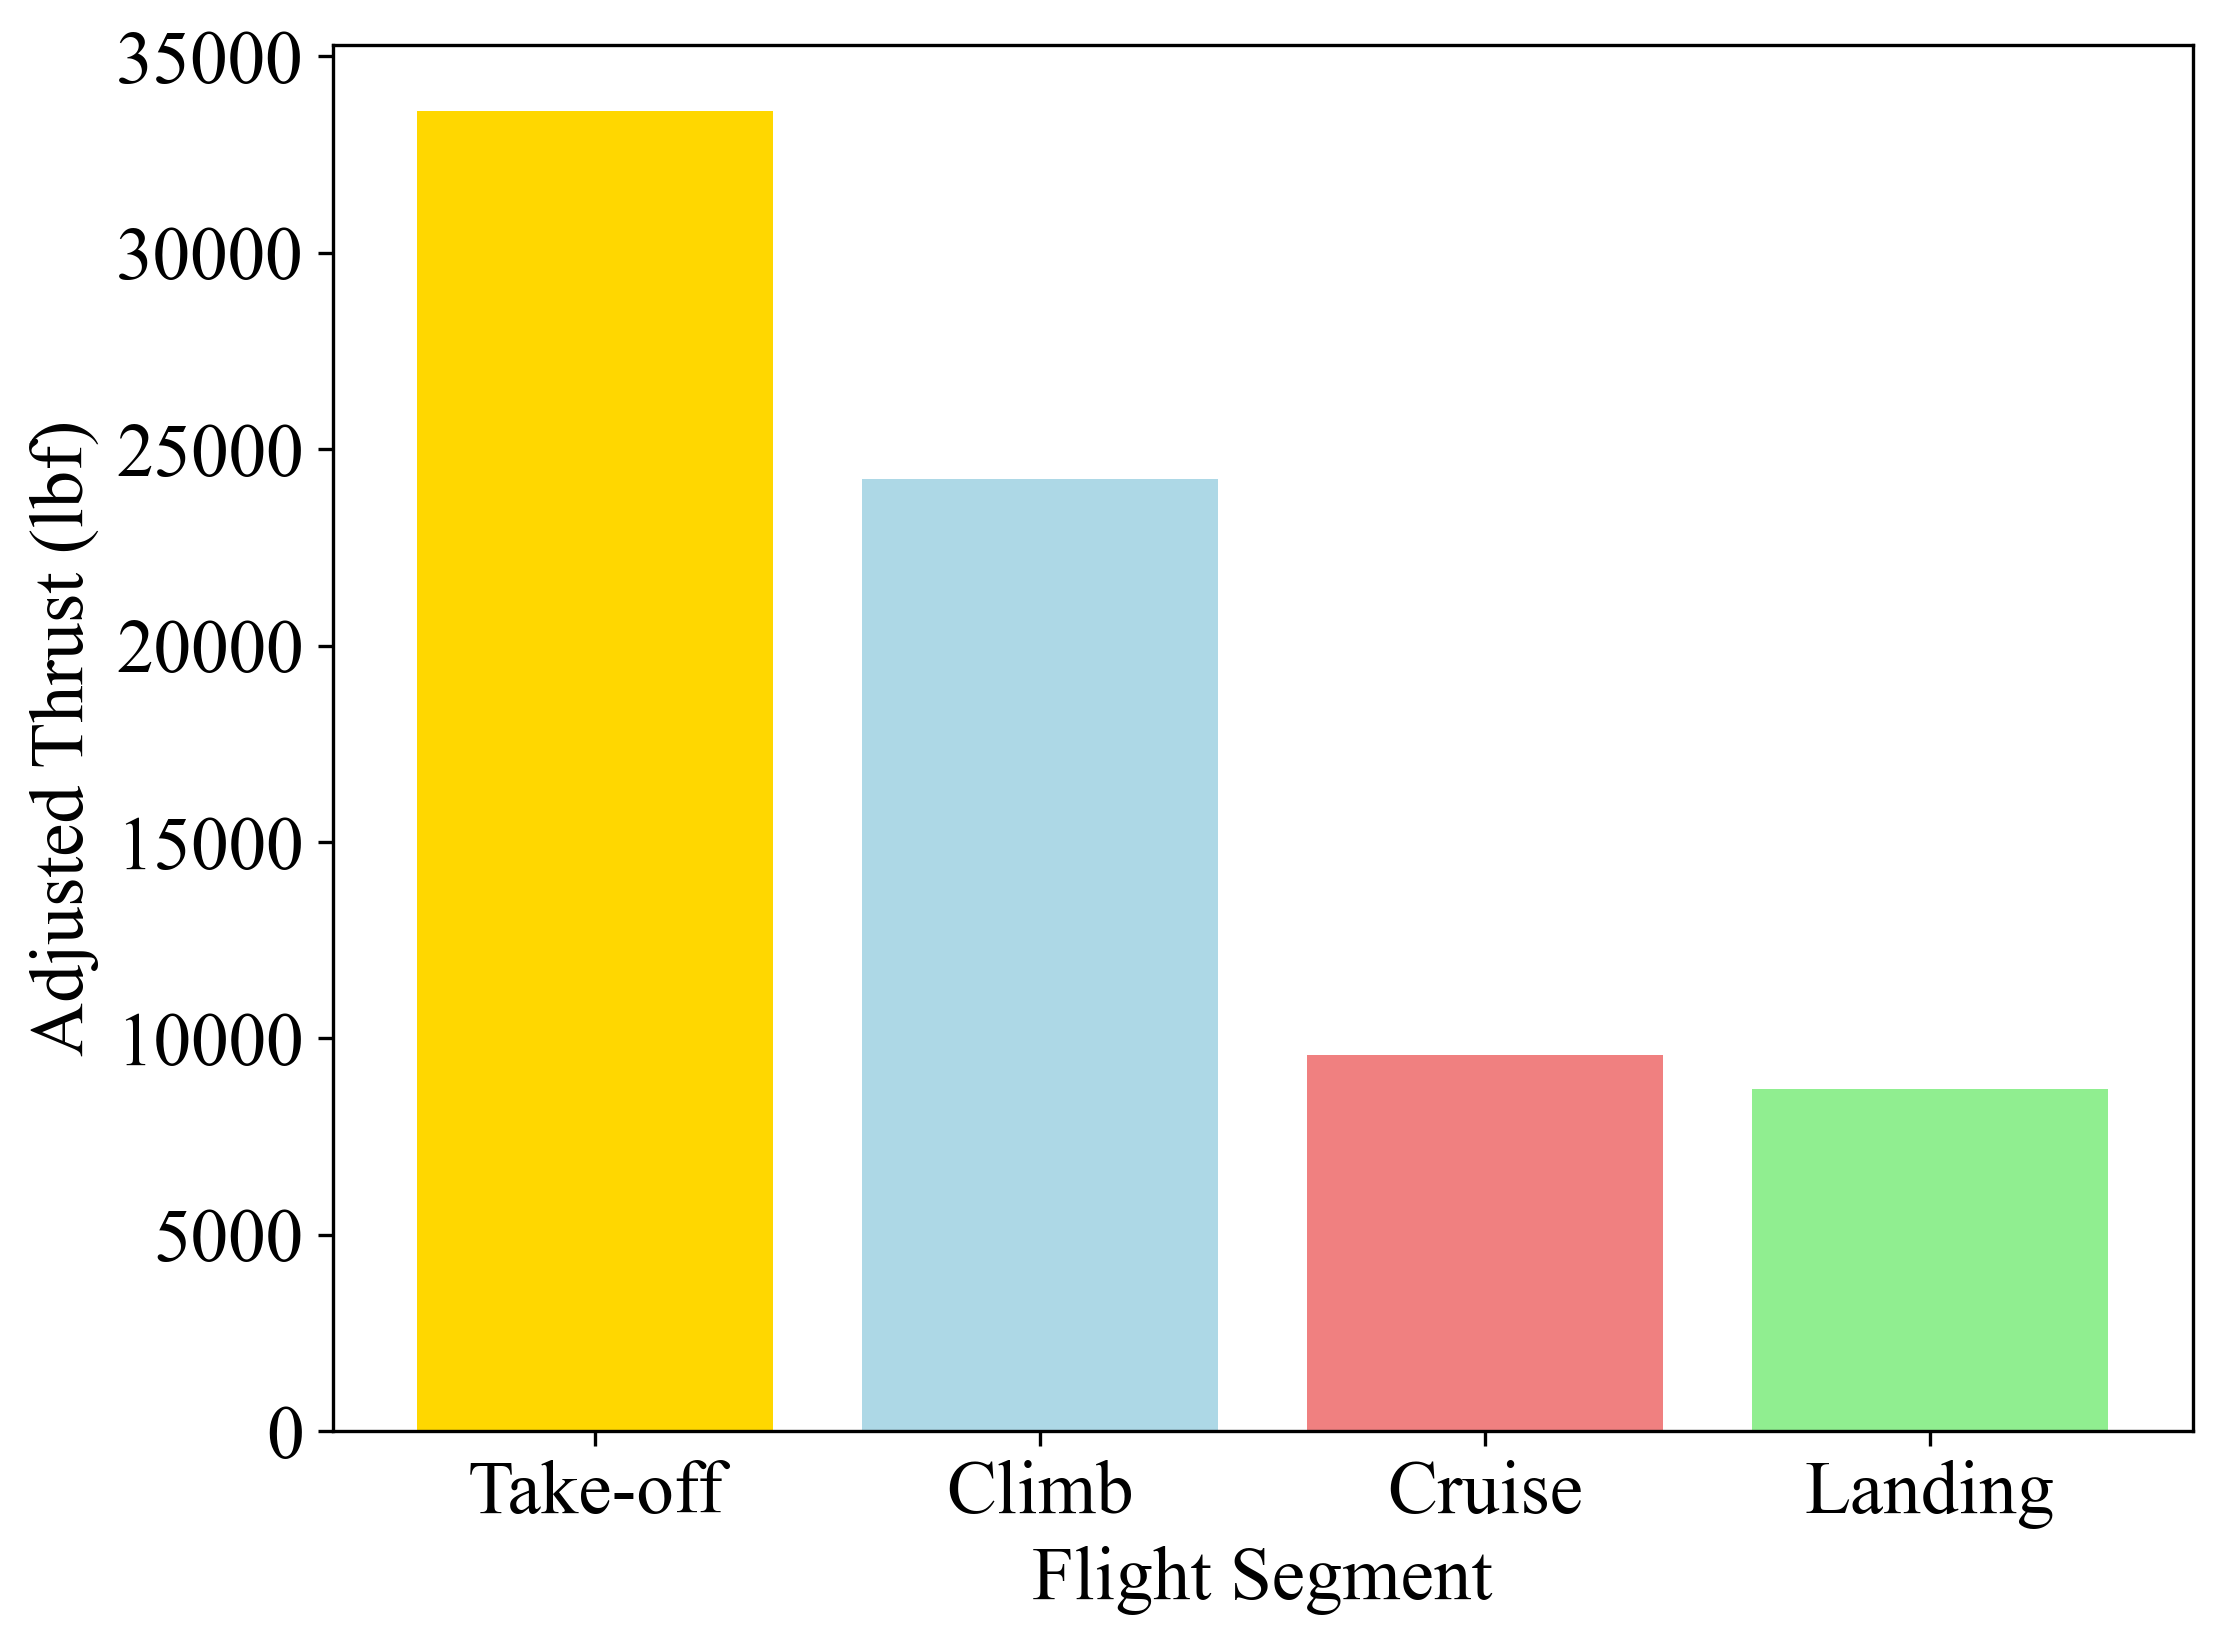

In [15]:
import matplotlib.pyplot as plt

# Data
flight_segments = ["Take-off", "Climb", "Cruise", "Landing"]
adjusted_thrust = [33606.51, 24237.72, 9586.21, 8717.35]


plt.rcParams["font.family"] = "Times New Roman"

# Create bar chart
plt.figure(figsize=(8, 6), dpi=300)
plt.bar(flight_segments, adjusted_thrust, color=['gold', 'lightblue', 'lightcoral', 'lightgreen'])

# Labels and title
plt.xlabel("Flight Segment", fontsize=18)  # Increase X-axis label font
plt.ylabel("Adjusted Thrust (lbf)", fontsize=18)  # Increase Y-axis label font
#plt.title("Adjusted Thrust Across Flight Segments", fontsize=16)  # Increase title font

# Increase tick label font size for both axes
plt.xticks(fontsize=18)  # Increase font size for X-axis numbers
plt.yticks(fontsize=18)  # Increase font size for Y-axis numbers

# Grid for better readability
#plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save the figure
plt.savefig("adjusted_thrust_bar_chart.png", dpi=300, bbox_inches="tight")

# Show the chart
plt.show()


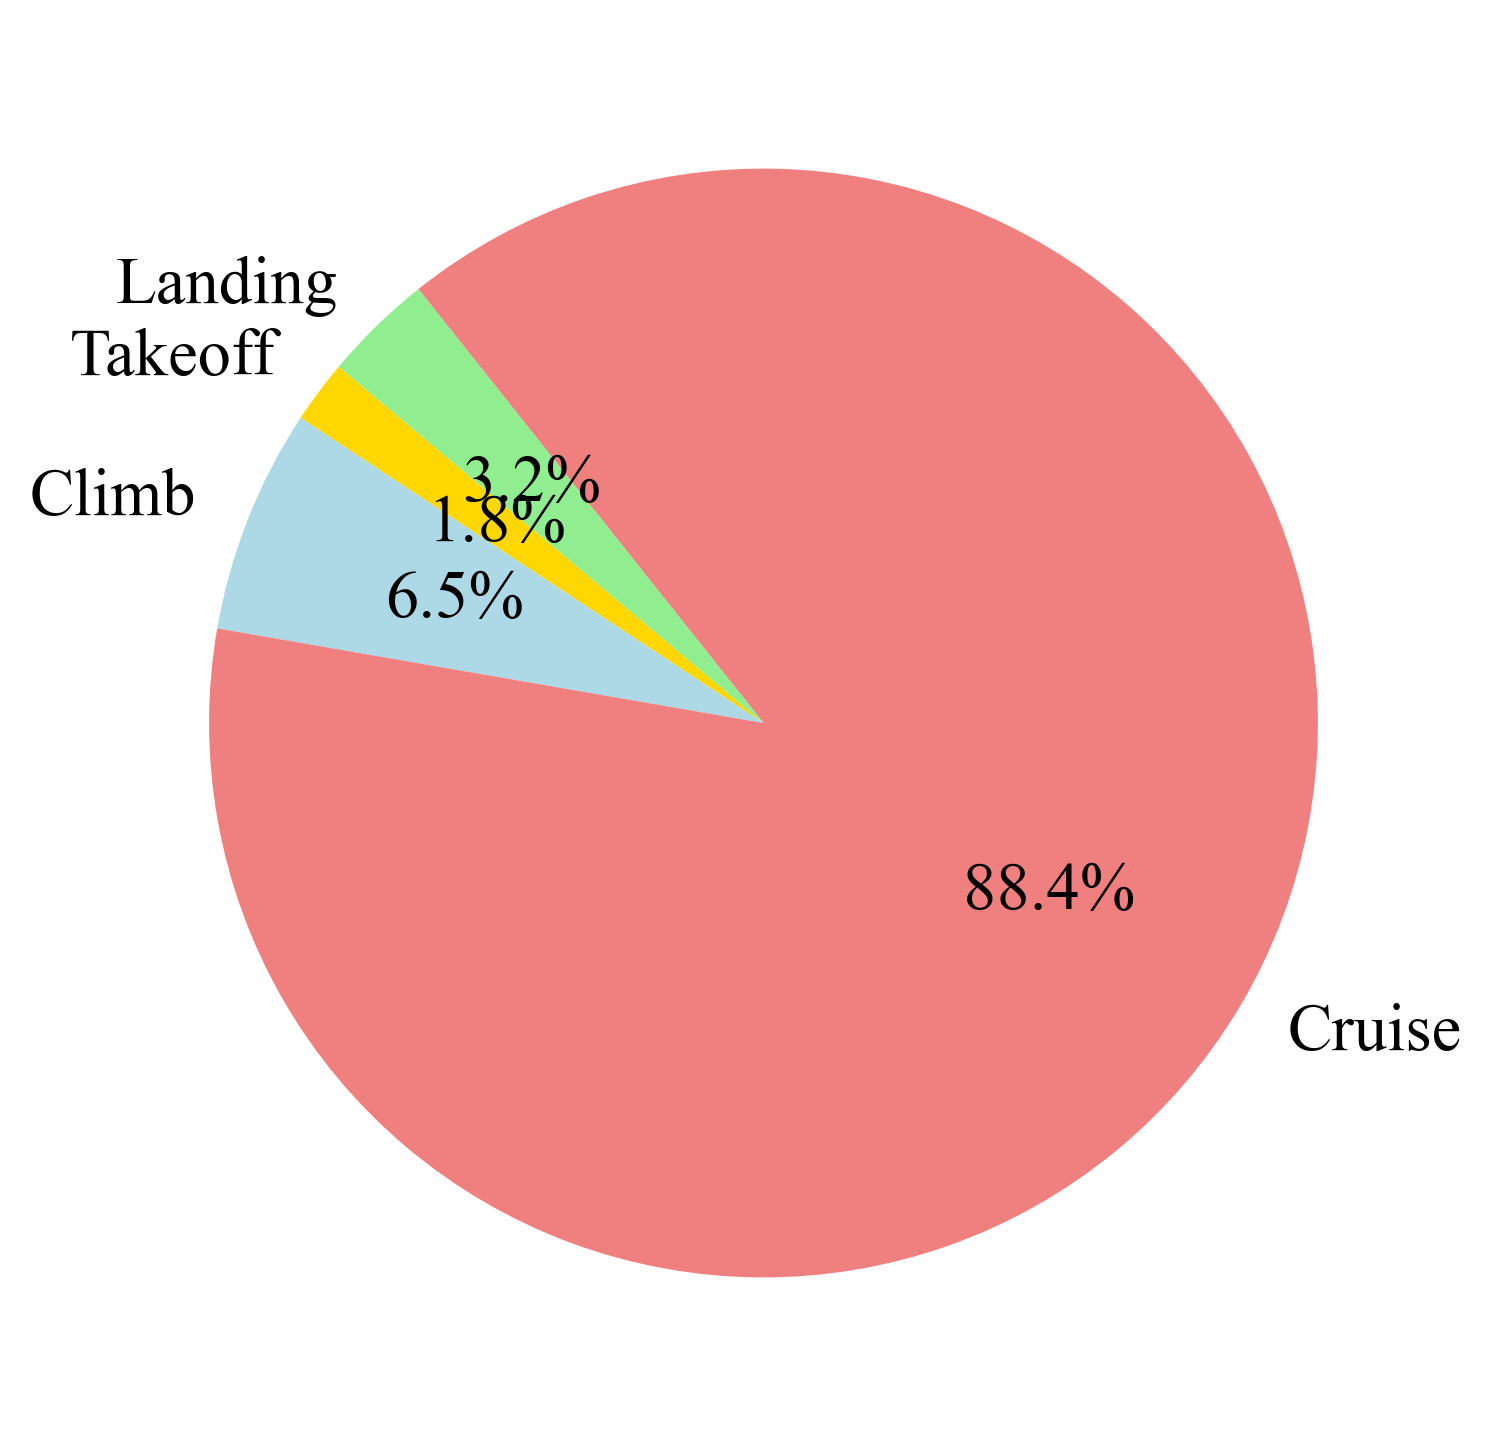

In [12]:
import matplotlib.pyplot as plt

# Data
labels = ['Takeoff', 'Climb', 'Cruise', 'Landing']
fuel_burn_lbs = [613.58, 2186.60, 29541.57, 1066.86]
colors = ['gold', 'lightblue', 'lightcoral', 'lightgreen']

# Set font size globally
plt.rcParams.update({'font.size': 14})  # Increases font size for all elements

# Create pie chart
plt.figure(figsize=(8, 6), dpi=300)
plt.pie(fuel_burn_lbs, labels=labels, autopct='%1.1f%%', colors=colors, 
        startangle=140, shadow=False, textprops={'fontsize': 16})  # Increase label font size

# Title with larger font
#plt.title('Fuel Burn Distribution Across Flight Phases', fontsize=18)

# Show the chart
plt.show()
